In [1]:
#%matplotlib notebook
import os
from datetime import datetime
from pathlib import Path
import math
import time
import numpy as np
import pandas as pd
from tabulate import tabulate
from matplotlib import pyplot as plt
import functools
import json

from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import importlib
import plt_utils as pu
import evaluator as ev
import SMOTER as smtr
import forecasting_models as fmod
import relevance as rlv
import prepare_data as dprep
import GAN as gmod

#allows update import custom modules without having to restart kernel:
importlib.reload(pu)
importlib.reload(ev)
importlib.reload(smtr)
importlib.reload(fmod)
importlib.reload(rlv)
importlib.reload(dprep)
importlib.reload(gmod)

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

2023-10-26 03:57:21.646885: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-26 03:57:22.101726: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-26 03:57:22.101745: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-10-26 03:57:23.517650: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

**Importing Data**

In [2]:
#If tvar and/or fvars not specified it'll just opt for the default specified by meta
def import_data(file_name, tvar=None, fvars=None):
    with open('data/meta.json','r') as file:
        meta = json.load(file)
    meta = meta[file_name]
    ds_name = meta['name']
    if file_name == 'london_merged.csv':
        #this dataset is multi-variate, can call this function with specified targets/features or just use defaults
        if not tvar: tvar = meta['tv']
        if not fvars: fvars = [tvar]
        df=pd.read_csv(f"data/{file_name}")
        df=df.reset_index()[fvars if tvar in fvars else [tvar] + fvars]
    else:
        #rest of the datasets are univariate and don't have headers
        tvar = meta['tv']
        fvars = [tvar]
        df=pd.read_csv(f"data/{file_name}", header=None, names=[tvar])
    return df, tvar, fvars, ds_name

#importing london_merged:
#DATA_FILE = 'london_merged.csv'
#df1, TVAR, FVARS, DATA_NAME = import_data(DATA_FILE)

#importing baseline:
DATA_FILE = 'lorenz.dat.txt'
df1, TVAR, FVARS, DATA_NAME = import_data(DATA_FILE)

N_FVARS = len(FVARS)
print(df1)

       Simulated Lorenz Values
0                    -0.156058
1                    -0.071057
2                     0.004560
3                     0.072342
4                     0.133683
...                        ...
16379                 7.229871
16380                 6.280668
16381                 5.387925
16382                 4.557258
16383                 3.791413

[16384 rows x 1 columns]


In [3]:
FORECASTERS = ["LSTM", "CNN"]

In [4]:
import recorder as rec
importlib.reload(rec)
to_save = {'forecast_models': False,
           'forecast_results': False,
           'resample_models': False, #best GANs 
           'resample_results': True,
           'eval_results': True, #evaluation metrics
           'logs': True,
           'figures': True,
           'parameters': True,
          }

RECORDER = rec.ExperimentRecorder(to_save, "Bike", FORECASTERS)
#LOADER = rec.ExperimentLoader(to_load, "Bike")
#load results from a previous session to compare with results from this session
#base_results_dir must contain resampling results and eval results to combine results
COMBINE_RESULTS_DIR = None #"Sessions/Bike/2023-October-13 13-41-03-532984"

#set GAN_DIR to none to train a new GAN, else give it a folder path to load from
GAN_CNN_DIR = None
GAN_FNN_DIR = None
#GAN_FNN_DIR = Path("C:\\Users\\jonny\\Documents\\RA\\EVF\\code\\thesis\\resampling\\Session Data\\2023-September-28 09-51-03-210656\\resample_models")

#set FORECAST_DIR to none to train a new LSTM, else give it a folder path to load from
FORECAST_DIR = None
#FORECAST_DIR = Path("C:\\Users\\jonny\\Documents\\RA\\EVF\\code\\thesis\\resampling\\Session Data\\2023-September-28 09-51-03-210656\\forecast_models")
loadedModels = {"loadedModels": {"GanCnnDir": GAN_CNN_DIR, "GanFnnDir":GAN_FNN_DIR, "ForecastDir": FORECAST_DIR}}
RECORDER.save_param_dict(loadedModels)

**Prepare Data for Resampling/Training**
* Split dataset into train and test split
* Convert data into Taken embedded time series format

In [5]:
RECORDER.log_print(f"Using data from: {DATA_FILE}")
RECORDER.log_print(f"Using feature variables: {FVARS} to predict target variable: '{TVAR}'")
RECORDER.save_param_dict({"importingData":{"dataFile":DATA_FILE,"targetVar":TVAR,"featVars":FVARS}})

df1 = np.array(df1).reshape(-1,N_FVARS)

scaler=MinMaxScaler(feature_range=(0,1))
df1 = df1.reshape(-1,N_FVARS)
scaled_data = scaler.fit_transform(df1) 
print(f"scaled_data: {scaled_data.shape}")

#Prep Data
N_STEPS_IN = 5
N_STEPS_OUT = 5
SPLIT_RATIO = 0.7
SAMPLE_DIM = N_STEPS_IN*N_FVARS + N_STEPS_OUT

k_X, X_train, Y_train, X_test, Y_test = dprep.split_data(scaled_data, N_STEPS_IN, N_STEPS_OUT, FVARS, N_FVARS, TVAR, SPLIT_RATIO)

RECORDER.save_param_dict({"prepData":{"nStepsIn":N_STEPS_IN,"nStepsOut":N_STEPS_OUT,"splitRatio":SPLIT_RATIO}})
RECORDER.log_print(f"Embedding steps in: {N_STEPS_IN} and steps out: {N_STEPS_OUT}")
RECORDER.log_print(f"Split dataset with training ratio: {SPLIT_RATIO}")
RECORDER.log_print(f"""Split data shapes:\n\t X_train: {X_train.shape}\n\t Y_train: {Y_train.shape}\n\t X_test: {X_test.shape}\n\t Y_test: {Y_test.shape}\n\t k_X: {k_X.shape}""")

LOG: 03:57:26:081 Using data from: lorenz.dat.txt

LOG: 03:57:26:082 Using feature variables: ['Simulated Lorenz Values'] to predict target variable: 'Simulated Lorenz Values'

scaled_data: (16384, 1)
LOG: 03:57:26:118 Embedding steps in: 5 and steps out: 5

LOG: 03:57:26:118 Split dataset with training ratio: 0.7

LOG: 03:57:26:119 Split data shapes:
	 X_train: (11462, 5, 1)
	 Y_train: (11462, 5)
	 X_test: (4913, 5, 1)
	 Y_test: (4913, 5)
	 k_X: (11462, 10)



**Relevance**

In [6]:
#give this guy a list of training target values and it will give you a function that you can input target values to get a relevance score
def getPoisRelFunc(y):
    sample_mean = np.mean(y) 
    sample_std = np.std(y)
    rel_quant = np.quantile(1/rlv.dpois(y,sample_mean),0.5)
    RECORDER.save_param_dict({"relevanceFunc":{"funcName":"Pois","funcParams":{}}})
    return functools.partial(rlv.poisRelevance, smean=sample_mean, sstd=sample_std, rshift=rel_quant)
    
def getPCHIPRelFunc(y, percs, rels):
    pchip = rlv.PCHIP_interpolator(y, percs, rels)
    RECORDER.save_param_dict({"relevanceFunc":{"funcName":"PCHIP","funcParams":{"percentages":list(percs),"rels":list(rels)}}})
    return functools.partial(rlv.PCHIPRelevance, pchip_func=pchip)

all_train_targets = np.append(Y_train[:,0],Y_train[-1,1:]) 
#RELEVANCE_THRESHOLD = 0.31
#RELEVANCE_FUNCTION = getPoisRelFunc(all_train_targets)
RELEVANCE_THRESHOLD = 0.8
pchip_percentiles = [25,95,99]#[25,50,75,95,99]
pchip_relevances = [0.0,0.75,1.0]#[0.0,0.25,0.5,0.75,1.0]
RELEVANCE_FUNCTION = getPCHIPRelFunc(all_train_targets, pchip_percentiles, pchip_relevances) 
EXTREMES_THRESHOLD = rlv.PCHIPApproxInverse(RELEVANCE_THRESHOLD, RELEVANCE_FUNCTION, 0, 0.99) #target value that intersects with RELEVANCE_THRESHOLD

COMBINE = 'first'
r_Y = RELEVANCE_FUNCTION.__call__(Y_train, combine=COMBINE)
k_Y = [val >= RELEVANCE_THRESHOLD for val in r_Y]

RECORDER.save_param_dict({"relevance":{"relThresh":RELEVANCE_THRESHOLD,"exThresh": EXTREMES_THRESHOLD}})

num_rel=k_Y.count(True)

RECORDER.log_print(f"Relevance function {RELEVANCE_FUNCTION.func.__name__} used with threshold: {RELEVANCE_THRESHOLD}")
RECORDER.log_print(f"Relevance {len(k_Y)-num_rel} common values, {num_rel} relevant values")

r_Y = np.array(r_Y)
k_Y = np.array(k_Y)
k_Xex = k_X[k_Y]
print(f"r_Y: {r_Y.shape}")
#print(r_Y)
print(f"k_Y: {k_Y.shape}")
#print(k_Y)
print(f"k_Xex: {k_Xex.shape}")

LOG: 03:57:26:145 Relevance function PCHIPRelevance used with threshold: 0.8

LOG: 03:57:26:145 Relevance 11025 common values, 437 relevant values

r_Y: (11462,)
k_Y: (11462,)
k_Xex: (437, 10)


***Plot Relevance Information***

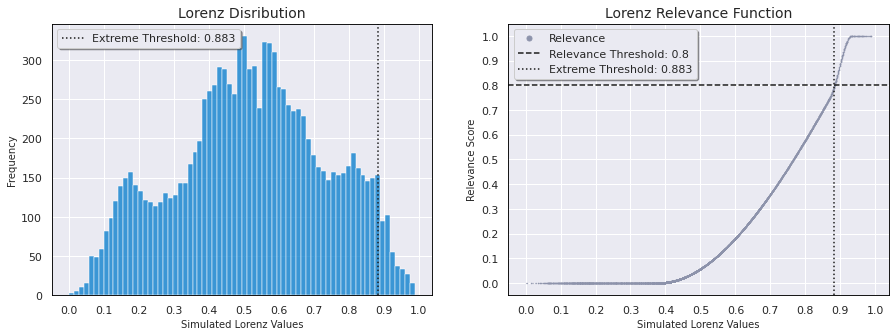

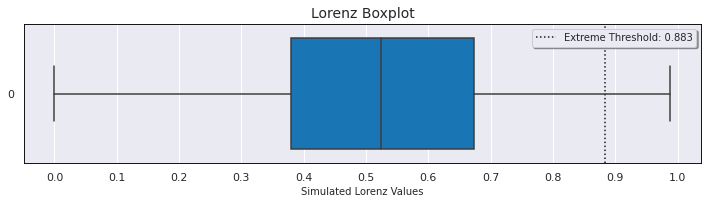

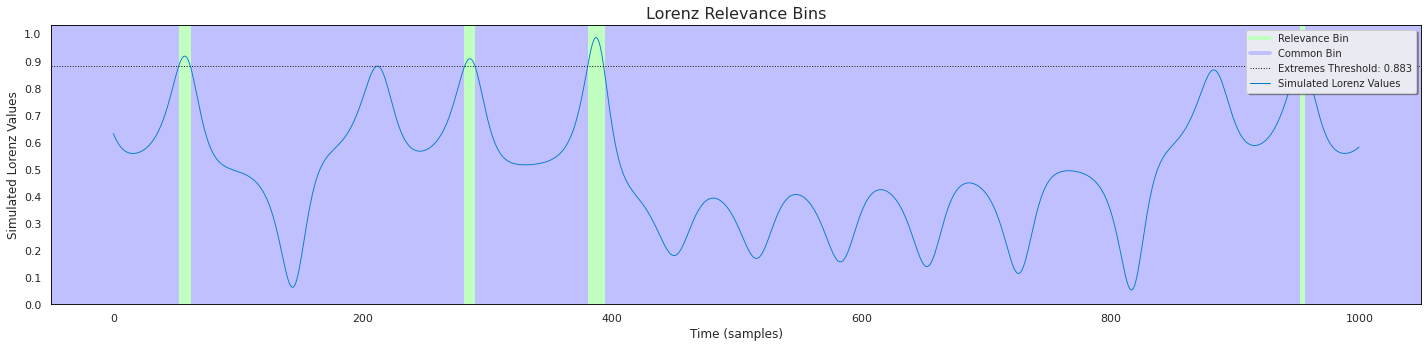

In [7]:
#Uncomment if you want to change stuff in plt_utils mid-session
#import plt_utils as pu
#importlib.reload(pu)
#Need to uncomment this is you're saving figures:
#pu.set_save_figs(True, RECORDER.figures_path)

#pu.PlotScaledData(data, TVAR)

r_Y_plot = RELEVANCE_FUNCTION.__call__(all_train_targets, combine=COMBINE) #relevance for plotting
k_Y_plot = [val >= RELEVANCE_THRESHOLD for val in r_Y_plot]
r_Y_plot = np.array(r_Y_plot)
k_Y_plot = np.array(k_Y_plot)

pu.PlotRelevance(all_train_targets, r_Y_plot, RELEVANCE_THRESHOLD, EXTREMES_THRESHOLD, TVAR, DATA_NAME)

#pu.PlotCaseWeightSurface(all_train_targets, RELEVANCE_FUNCTION, EXTREMES_THRESHOLD, 0.5, TVAR)
#pu.PlotUtilitySurface(all_train_targets, RELEVANCE_FUNCTION, EXTREMES_THRESHOLD, 0.5, TVAR)

#pu.PlotBins(all_train_targets,k_Y_plot,EXTREMES_THRESHOLD, TVAR, DATA_NAME)
pu.PlotBins(all_train_targets[3000:4000],k_Y_plot[3000:4000],EXTREMES_THRESHOLD, TVAR, DATA_NAME)

# **Resampling**

In [8]:
RES_STRATS = ["SMOTER_regular", "SMOTER_bin", "SMOTER_bin_t", "SMOTER_bin_r", "SMOTER_bin_tr", "GAN_CNN", "GAN_FNN"]

**Define GAN Models**

In [9]:
import GAN as gmod
importlib.reload(gmod)

n_gan_epochs = 120
gan_batch_size = 128

CNN_GENS=None; CNN_DISCS=None; FNN_GENS=None; FNN_DISC=None

if "GAN_CNN" in RES_STRATS:
    CNN_GENS, CNN_DISCS = gmod.getGAN(k_Xex,GAN_CNN_DIR, "CNN", SAMPLE_DIM, n_gan_epochs, gan_batch_size, RECORDER.log_print)
if "GAN_FNN" in RES_STRATS:
    FNN_GENS, FNN_DISCS = gmod.getGAN(k_Xex,GAN_FNN_DIR, "FNN", SAMPLE_DIM, n_gan_epochs, gan_batch_size, RECORDER.log_print)

RECORDER.save_param_dict({"GAN":{"nEpochs":n_gan_epochs,"batchSize": gan_batch_size}})
print("$$$$ Finished training GANs $$$$")

LOG: 03:57:27:438 Training CNN GAN with 120 epochs



  0%|          | 0/4 [00:00<?, ?it/s]

Step 1: Generator loss: 1.3037987351417542, discriminator loss: 1.351527988910675
Step 2: Generator loss: 0.6256759166717529, discriminator loss: 0.6779390573501587
Step 3: Generator loss: 0.6104802489280701, discriminator loss: 0.6793394684791565


  0%|          | 0/4 [00:00<?, ?it/s]

Step 4: Generator loss: 0.5995891690254211, discriminator loss: 0.681808590888977
Step 5: Generator loss: 0.5922126770019531, discriminator loss: 0.6845012903213501
Step 6: Generator loss: 0.5875630974769592, discriminator loss: 0.6857190132141113
Step 7: Generator loss: 0.5882502198219299, discriminator loss: 0.6880474090576172


  0%|          | 0/4 [00:00<?, ?it/s]

Step 8: Generator loss: 0.5876656174659729, discriminator loss: 0.6891555786132812
Step 9: Generator loss: 0.5916144251823425, discriminator loss: 0.6902985572814941
Step 10: Generator loss: 0.5976403951644897, discriminator loss: 0.6907505989074707
Step 11: Generator loss: 0.6054818034172058, discriminator loss: 0.6917457580566406


  0%|          | 0/4 [00:00<?, ?it/s]

Step 12: Generator loss: 0.6145962476730347, discriminator loss: 0.6923612356185913
Step 13: Generator loss: 0.6251070499420166, discriminator loss: 0.6928369998931885
Step 14: Generator loss: 0.6369097232818604, discriminator loss: 0.6936600804328918
Step 15: Generator loss: 0.6483749747276306, discriminator loss: 0.6942296028137207


  0%|          | 0/4 [00:00<?, ?it/s]

Step 16: Generator loss: 0.661497175693512, discriminator loss: 0.6942935585975647
Step 17: Generator loss: 0.6753706932067871, discriminator loss: 0.6956728100776672
Step 18: Generator loss: 0.6900020837783813, discriminator loss: 0.6962599754333496
Step 19: Generator loss: 0.7047598361968994, discriminator loss: 0.6962164640426636


  0%|          | 0/4 [00:00<?, ?it/s]

Step 20: Generator loss: 0.7177484035491943, discriminator loss: 0.6969614028930664
Step 21: Generator loss: 0.7305889129638672, discriminator loss: 0.6976563334465027
Step 22: Generator loss: 0.74164879322052, discriminator loss: 0.6980078816413879
Step 23: Generator loss: 0.7509179711341858, discriminator loss: 0.6989511251449585


  0%|          | 0/4 [00:00<?, ?it/s]

Step 24: Generator loss: 0.7582409381866455, discriminator loss: 0.699312686920166
Step 25: Generator loss: 0.76326584815979, discriminator loss: 0.6995106935501099
Step 26: Generator loss: 0.766109049320221, discriminator loss: 0.6999560594558716
Step 27: Generator loss: 0.7665091753005981, discriminator loss: 0.6999721527099609


  0%|          | 0/4 [00:00<?, ?it/s]

Step 28: Generator loss: 0.7652080655097961, discriminator loss: 0.6999400854110718
Step 29: Generator loss: 0.7620453238487244, discriminator loss: 0.6999765634536743
Step 30: Generator loss: 0.7576188445091248, discriminator loss: 0.6997636556625366
Step 31: Generator loss: 0.7520673274993896, discriminator loss: 0.6993162631988525


  0%|          | 0/4 [00:00<?, ?it/s]

Step 32: Generator loss: 0.7458271980285645, discriminator loss: 0.6987596750259399
Step 33: Generator loss: 0.7390516996383667, discriminator loss: 0.6983605623245239
Step 34: Generator loss: 0.7318804860115051, discriminator loss: 0.6983281373977661
Step 35: Generator loss: 0.724747359752655, discriminator loss: 0.6977897882461548


  0%|          | 0/4 [00:00<?, ?it/s]

Step 36: Generator loss: 0.7179158329963684, discriminator loss: 0.6978468298912048
Step 37: Generator loss: 0.7114505767822266, discriminator loss: 0.6974494457244873
Step 38: Generator loss: 0.7055070996284485, discriminator loss: 0.6978307962417603
Step 39: Generator loss: 0.7004303932189941, discriminator loss: 0.6976009607315063


  0%|          | 0/4 [00:00<?, ?it/s]

Step 40: Generator loss: 0.6963140964508057, discriminator loss: 0.698275089263916
Step 41: Generator loss: 0.6932157874107361, discriminator loss: 0.6984819769859314
Step 42: Generator loss: 0.691119372844696, discriminator loss: 0.698921263217926
Step 43: Generator loss: 0.6898334622383118, discriminator loss: 0.699381411075592


  0%|          | 0/4 [00:00<?, ?it/s]

Step 44: Generator loss: 0.6898054480552673, discriminator loss: 0.6995304226875305
Step 45: Generator loss: 0.6906643509864807, discriminator loss: 0.6998648643493652
Step 46: Generator loss: 0.6919980645179749, discriminator loss: 0.7000452280044556
Step 47: Generator loss: 0.6939811110496521, discriminator loss: 0.7008206248283386


  0%|          | 0/4 [00:00<?, ?it/s]

Step 48: Generator loss: 0.6963070631027222, discriminator loss: 0.7003778219223022
Step 49: Generator loss: 0.6992686986923218, discriminator loss: 0.6999295949935913
Step 50: Generator loss: 0.7027134895324707, discriminator loss: 0.6991088390350342
Step 51: Generator loss: 0.7069714665412903, discriminator loss: 0.6982555389404297


  0%|          | 0/4 [00:00<?, ?it/s]

Step 52: Generator loss: 0.7113968133926392, discriminator loss: 0.6965168118476868
Step 53: Generator loss: 0.7163625955581665, discriminator loss: 0.6943889856338501
Step 54: Generator loss: 0.7208178639411926, discriminator loss: 0.6921910047531128
Step 55: Generator loss: 0.7248116731643677, discriminator loss: 0.6901293992996216


  0%|          | 0/4 [00:00<?, ?it/s]

Step 56: Generator loss: 0.7283287048339844, discriminator loss: 0.6871858835220337
Step 57: Generator loss: 0.7299488186836243, discriminator loss: 0.6855639219284058
Step 58: Generator loss: 0.7319559454917908, discriminator loss: 0.6831775903701782
Step 59: Generator loss: 0.7332899570465088, discriminator loss: 0.6808669567108154


  0%|          | 0/4 [00:00<?, ?it/s]

Step 60: Generator loss: 0.7343233823776245, discriminator loss: 0.678756594657898
Step 61: Generator loss: 0.7344495058059692, discriminator loss: 0.6775020956993103
Step 62: Generator loss: 0.7336878776550293, discriminator loss: 0.6759169101715088
Step 63: Generator loss: 0.7300258278846741, discriminator loss: 0.6767667531967163


  0%|          | 0/4 [00:00<?, ?it/s]

Step 64: Generator loss: 0.7260088324546814, discriminator loss: 0.6765727996826172
Step 65: Generator loss: 0.7202194333076477, discriminator loss: 0.679274320602417
Step 66: Generator loss: 0.7114994525909424, discriminator loss: 0.6817179918289185
Step 67: Generator loss: 0.7049078345298767, discriminator loss: 0.6853935718536377


  0%|          | 0/4 [00:00<?, ?it/s]

Step 68: Generator loss: 0.6988774538040161, discriminator loss: 0.6889018416404724
Step 69: Generator loss: 0.694225549697876, discriminator loss: 0.6915605068206787
Step 70: Generator loss: 0.6934216022491455, discriminator loss: 0.6941327452659607
Step 71: Generator loss: 0.6938372850418091, discriminator loss: 0.696164608001709


  0%|          | 0/4 [00:00<?, ?it/s]

Step 72: Generator loss: 0.6960867643356323, discriminator loss: 0.6972053050994873
Step 73: Generator loss: 0.6992089152336121, discriminator loss: 0.6982578635215759
Step 74: Generator loss: 0.7024521231651306, discriminator loss: 0.6992461681365967
Step 75: Generator loss: 0.7064827084541321, discriminator loss: 0.7002261877059937


  0%|          | 0/4 [00:00<?, ?it/s]

Step 76: Generator loss: 0.710031270980835, discriminator loss: 0.7010387778282166
Step 77: Generator loss: 0.7132434844970703, discriminator loss: 0.7013212442398071
Step 78: Generator loss: 0.7167211771011353, discriminator loss: 0.7012386322021484
Step 79: Generator loss: 0.7208117842674255, discriminator loss: 0.7009351253509521


  0%|          | 0/4 [00:00<?, ?it/s]

Step 80: Generator loss: 0.7248317003250122, discriminator loss: 0.6994088292121887
Step 81: Generator loss: 0.7283653616905212, discriminator loss: 0.6974456310272217
Step 82: Generator loss: 0.7312995195388794, discriminator loss: 0.6949244737625122
Step 83: Generator loss: 0.7317129373550415, discriminator loss: 0.6922813653945923


  0%|          | 0/4 [00:00<?, ?it/s]

Step 84: Generator loss: 0.7312813997268677, discriminator loss: 0.6898078918457031
Step 85: Generator loss: 0.7294844388961792, discriminator loss: 0.6883556842803955
Step 86: Generator loss: 0.7261014580726624, discriminator loss: 0.6868975162506104
Step 87: Generator loss: 0.7208152413368225, discriminator loss: 0.6860095858573914


  0%|          | 0/4 [00:00<?, ?it/s]

Step 88: Generator loss: 0.7139167189598083, discriminator loss: 0.6848939657211304
Step 89: Generator loss: 0.705316960811615, discriminator loss: 0.6847007274627686
Step 90: Generator loss: 0.6946942806243896, discriminator loss: 0.6871585249900818
Step 91: Generator loss: 0.6766169667243958, discriminator loss: 0.6907557249069214


  0%|          | 0/4 [00:00<?, ?it/s]

Step 92: Generator loss: 0.6663482189178467, discriminator loss: 0.6955949664115906
Step 93: Generator loss: 0.6537004709243774, discriminator loss: 0.6984233856201172
Step 94: Generator loss: 0.6438985466957092, discriminator loss: 0.7014449834823608
Step 95: Generator loss: 0.6393100023269653, discriminator loss: 0.7036581039428711


  0%|          | 0/4 [00:00<?, ?it/s]

Step 96: Generator loss: 0.637941300868988, discriminator loss: 0.7040551900863647
Step 97: Generator loss: 0.6395308971405029, discriminator loss: 0.7020472884178162
Step 98: Generator loss: 0.6463054418563843, discriminator loss: 0.6981502771377563
Step 99: Generator loss: 0.6556251645088196, discriminator loss: 0.692173182964325


  0%|          | 0/4 [00:00<?, ?it/s]

Step 100: Generator loss: 0.6688121557235718, discriminator loss: 0.6843769550323486
Step 101: Generator loss: 0.6842870116233826, discriminator loss: 0.6749653816223145
Step 102: Generator loss: 0.7012057304382324, discriminator loss: 0.6647186279296875
Step 103: Generator loss: 0.7192125916481018, discriminator loss: 0.6534842252731323


  0%|          | 0/4 [00:00<?, ?it/s]

Step 104: Generator loss: 0.7376828193664551, discriminator loss: 0.642562985420227
Step 105: Generator loss: 0.7561807036399841, discriminator loss: 0.6310341358184814
Step 106: Generator loss: 0.7745388150215149, discriminator loss: 0.619861364364624
Step 107: Generator loss: 0.79286128282547, discriminator loss: 0.6078012585639954


  0%|          | 0/4 [00:00<?, ?it/s]

Step 108: Generator loss: 0.8103927373886108, discriminator loss: 0.5965696573257446
Step 109: Generator loss: 0.8276724815368652, discriminator loss: 0.5859726667404175
Step 110: Generator loss: 0.8443107008934021, discriminator loss: 0.5755810141563416
Step 111: Generator loss: 0.8604705333709717, discriminator loss: 0.563377320766449


  0%|          | 0/4 [00:00<?, ?it/s]

Step 112: Generator loss: 0.8758483529090881, discriminator loss: 0.5534646511077881
Step 113: Generator loss: 0.8907524347305298, discriminator loss: 0.5437089204788208
Step 114: Generator loss: 0.9051117300987244, discriminator loss: 0.5328055620193481
Step 115: Generator loss: 0.9190724492073059, discriminator loss: 0.5230598449707031


  0%|          | 0/4 [00:00<?, ?it/s]

Step 116: Generator loss: 0.9319599866867065, discriminator loss: 0.5136355757713318
Step 117: Generator loss: 0.9443148970603943, discriminator loss: 0.5041269063949585
Step 118: Generator loss: 0.956182062625885, discriminator loss: 0.4957413971424103
Step 119: Generator loss: 0.967557430267334, discriminator loss: 0.48727476596832275


  0%|          | 0/4 [00:00<?, ?it/s]

Step 120: Generator loss: 0.975965142250061, discriminator loss: 0.47945672273635864
Step 121: Generator loss: 0.9833207726478577, discriminator loss: 0.47133922576904297
Step 122: Generator loss: 0.9851616621017456, discriminator loss: 0.46674633026123047
Step 123: Generator loss: 0.9820532202720642, discriminator loss: 0.46273142099380493


  0%|          | 0/4 [00:00<?, ?it/s]

Step 124: Generator loss: 0.9700645804405212, discriminator loss: 0.4615236520767212
Step 125: Generator loss: 0.9494741559028625, discriminator loss: 0.4632037878036499
Step 126: Generator loss: 0.9212482571601868, discriminator loss: 0.4721505641937256
Step 127: Generator loss: 0.8924078345298767, discriminator loss: 0.4805302619934082


  0%|          | 0/4 [00:00<?, ?it/s]

Step 128: Generator loss: 0.8749063014984131, discriminator loss: 0.48366206884384155
Step 129: Generator loss: 0.8642258644104004, discriminator loss: 0.4871099293231964
Step 130: Generator loss: 0.8664685487747192, discriminator loss: 0.4860955476760864
Step 131: Generator loss: 0.8781843185424805, discriminator loss: 0.4821805953979492


  0%|          | 0/4 [00:00<?, ?it/s]

Step 132: Generator loss: 0.8936102986335754, discriminator loss: 0.47821104526519775
Step 133: Generator loss: 0.9138386845588684, discriminator loss: 0.4726795554161072
Step 134: Generator loss: 0.9367895722389221, discriminator loss: 0.4670308232307434
Step 135: Generator loss: 0.9606115818023682, discriminator loss: 0.4599054455757141


  0%|          | 0/4 [00:00<?, ?it/s]

Step 136: Generator loss: 0.9851208329200745, discriminator loss: 0.4540677070617676
Step 137: Generator loss: 1.0088938474655151, discriminator loss: 0.44937506318092346
Step 138: Generator loss: 1.0312867164611816, discriminator loss: 0.4433610439300537
Step 139: Generator loss: 1.0526025295257568, discriminator loss: 0.4393733739852905


  0%|          | 0/4 [00:00<?, ?it/s]

Step 140: Generator loss: 1.0707892179489136, discriminator loss: 0.43271225690841675
Step 141: Generator loss: 1.0849045515060425, discriminator loss: 0.4301532208919525
Step 142: Generator loss: 1.0929410457611084, discriminator loss: 0.42829984426498413
Step 143: Generator loss: 1.0908111333847046, discriminator loss: 0.4273812472820282


  0%|          | 0/4 [00:00<?, ?it/s]

Step 144: Generator loss: 1.0799493789672852, discriminator loss: 0.42875874042510986
Step 145: Generator loss: 1.0460225343704224, discriminator loss: 0.43853557109832764
Step 146: Generator loss: 0.9889426827430725, discriminator loss: 0.4516681134700775
Step 147: Generator loss: 0.9174492955207825, discriminator loss: 0.4717499315738678


  0%|          | 0/4 [00:00<?, ?it/s]

Step 148: Generator loss: 0.832372784614563, discriminator loss: 0.5075264573097229
Step 149: Generator loss: 0.7454516887664795, discriminator loss: 0.5375960469245911
Step 150: Generator loss: 0.6930024027824402, discriminator loss: 0.571021318435669
Step 151: Generator loss: 0.6535895466804504, discriminator loss: 0.595002293586731


  0%|          | 0/4 [00:00<?, ?it/s]

Step 152: Generator loss: 0.6461975574493408, discriminator loss: 0.6059961318969727
Step 153: Generator loss: 0.6518730521202087, discriminator loss: 0.6056244373321533
Step 154: Generator loss: 0.6672992706298828, discriminator loss: 0.6032805442810059
Step 155: Generator loss: 0.6845353245735168, discriminator loss: 0.600566029548645


  0%|          | 0/4 [00:00<?, ?it/s]

Step 156: Generator loss: 0.6968685984611511, discriminator loss: 0.5992628931999207
Step 157: Generator loss: 0.7050548791885376, discriminator loss: 0.6012645959854126
Step 158: Generator loss: 0.7033231258392334, discriminator loss: 0.6116766929626465
Step 159: Generator loss: 0.6942295432090759, discriminator loss: 0.6198843717575073


  0%|          | 0/4 [00:00<?, ?it/s]

Step 160: Generator loss: 0.6884172558784485, discriminator loss: 0.6255508661270142
Step 161: Generator loss: 0.6932269930839539, discriminator loss: 0.6278464794158936
Step 162: Generator loss: 0.7082443237304688, discriminator loss: 0.62571120262146
Step 163: Generator loss: 0.7279671430587769, discriminator loss: 0.6203854084014893


  0%|          | 0/4 [00:00<?, ?it/s]

Step 164: Generator loss: 0.7522172927856445, discriminator loss: 0.6079143285751343
Step 165: Generator loss: 0.778029203414917, discriminator loss: 0.597931444644928
Step 166: Generator loss: 0.8039955496788025, discriminator loss: 0.5846568942070007
Step 167: Generator loss: 0.8296980857849121, discriminator loss: 0.5734902620315552


  0%|          | 0/4 [00:00<?, ?it/s]

Step 168: Generator loss: 0.8542616963386536, discriminator loss: 0.5615556240081787
Step 169: Generator loss: 0.8778309226036072, discriminator loss: 0.547632098197937
Step 170: Generator loss: 0.9001694917678833, discriminator loss: 0.5341070294380188
Step 171: Generator loss: 0.9214678406715393, discriminator loss: 0.517327606678009


  0%|          | 0/4 [00:00<?, ?it/s]

Step 172: Generator loss: 0.9416452050209045, discriminator loss: 0.5085985660552979
Step 173: Generator loss: 0.9607182145118713, discriminator loss: 0.4974825382232666
Step 174: Generator loss: 0.9786919355392456, discriminator loss: 0.48290348052978516
Step 175: Generator loss: 0.9959444999694824, discriminator loss: 0.47308433055877686


  0%|          | 0/4 [00:00<?, ?it/s]

Step 176: Generator loss: 1.0121934413909912, discriminator loss: 0.46098506450653076
Step 177: Generator loss: 1.027794599533081, discriminator loss: 0.44684889912605286
Step 178: Generator loss: 1.0431770086288452, discriminator loss: 0.4384917616844177
Step 179: Generator loss: 1.0579288005828857, discriminator loss: 0.427179753780365


  0%|          | 0/4 [00:00<?, ?it/s]

Step 180: Generator loss: 1.0726830959320068, discriminator loss: 0.4171398878097534
Step 181: Generator loss: 1.087315559387207, discriminator loss: 0.40604132413864136
Step 182: Generator loss: 1.1019707918167114, discriminator loss: 0.396639347076416
Step 183: Generator loss: 1.116365671157837, discriminator loss: 0.38379234075546265


  0%|          | 0/4 [00:00<?, ?it/s]

Step 184: Generator loss: 1.1317235231399536, discriminator loss: 0.3782731294631958
Step 185: Generator loss: 1.146651029586792, discriminator loss: 0.368105411529541
Step 186: Generator loss: 1.1622315645217896, discriminator loss: 0.35941082239151
Step 187: Generator loss: 1.1779496669769287, discriminator loss: 0.35396793484687805


  0%|          | 0/4 [00:00<?, ?it/s]

Step 188: Generator loss: 1.1933403015136719, discriminator loss: 0.3447982668876648
Step 189: Generator loss: 1.2090389728546143, discriminator loss: 0.3368380069732666
Step 190: Generator loss: 1.2239875793457031, discriminator loss: 0.3287550210952759
Step 191: Generator loss: 1.238726258277893, discriminator loss: 0.32148584723472595


  0%|          | 0/4 [00:00<?, ?it/s]

Step 192: Generator loss: 1.2499006986618042, discriminator loss: 0.31701183319091797
Step 193: Generator loss: 1.2554850578308105, discriminator loss: 0.31223875284194946
Step 194: Generator loss: 1.2520503997802734, discriminator loss: 0.3115283250808716
Step 195: Generator loss: 1.2307344675064087, discriminator loss: 0.3114982843399048


  0%|          | 0/4 [00:00<?, ?it/s]

Step 196: Generator loss: 1.1807026863098145, discriminator loss: 0.3234866261482239
Step 197: Generator loss: 1.0908713340759277, discriminator loss: 0.3394019603729248
Step 198: Generator loss: 0.9844058752059937, discriminator loss: 0.371296763420105
Step 199: Generator loss: 0.8747393488883972, discriminator loss: 0.4182332158088684


  0%|          | 0/4 [00:00<?, ?it/s]

Step 200: Generator loss: 0.7829493284225464, discriminator loss: 0.4438118040561676
Step 201: Generator loss: 0.7323972582817078, discriminator loss: 0.4727969765663147
Step 202: Generator loss: 0.721892237663269, discriminator loss: 0.4810643792152405
Step 203: Generator loss: 0.7283549904823303, discriminator loss: 0.48317787051200867


  0%|          | 0/4 [00:00<?, ?it/s]

Step 204: Generator loss: 0.7343851923942566, discriminator loss: 0.4853948950767517
Step 205: Generator loss: 0.7375415563583374, discriminator loss: 0.49018415808677673
Step 206: Generator loss: 0.7317074537277222, discriminator loss: 0.49796900153160095
Step 207: Generator loss: 0.7275918126106262, discriminator loss: 0.5074083805084229


  0%|          | 0/4 [00:00<?, ?it/s]

Step 208: Generator loss: 0.7351980209350586, discriminator loss: 0.5116852521896362
Step 209: Generator loss: 0.7524381875991821, discriminator loss: 0.506632387638092
Step 210: Generator loss: 0.7818387746810913, discriminator loss: 0.502336859703064
Step 211: Generator loss: 0.8164679408073425, discriminator loss: 0.4926150441169739


  0%|          | 0/4 [00:00<?, ?it/s]

Step 212: Generator loss: 0.8510739207267761, discriminator loss: 0.483519971370697
Step 213: Generator loss: 0.8785399198532104, discriminator loss: 0.4803188443183899
Step 214: Generator loss: 0.8998469114303589, discriminator loss: 0.47894802689552307
Step 215: Generator loss: 0.9084584712982178, discriminator loss: 0.4732561409473419


  0%|          | 0/4 [00:00<?, ?it/s]

Step 216: Generator loss: 0.913641095161438, discriminator loss: 0.4758717119693756
Step 217: Generator loss: 0.9222173094749451, discriminator loss: 0.4756564497947693
Step 218: Generator loss: 0.9371693134307861, discriminator loss: 0.47167885303497314
Step 219: Generator loss: 0.9585847854614258, discriminator loss: 0.4617999196052551


  0%|          | 0/4 [00:00<?, ?it/s]

Step 220: Generator loss: 0.9860417246818542, discriminator loss: 0.4535568058490753
Step 221: Generator loss: 1.0139803886413574, discriminator loss: 0.44380414485931396
Step 222: Generator loss: 1.0419529676437378, discriminator loss: 0.43299365043640137
Step 223: Generator loss: 1.0686734914779663, discriminator loss: 0.42317742109298706


  0%|          | 0/4 [00:00<?, ?it/s]

Step 224: Generator loss: 1.0941576957702637, discriminator loss: 0.4113326668739319
Step 225: Generator loss: 1.1180742979049683, discriminator loss: 0.40235742926597595
Step 226: Generator loss: 1.1407625675201416, discriminator loss: 0.3891142010688782
Step 227: Generator loss: 1.162079095840454, discriminator loss: 0.3802240192890167


  0%|          | 0/4 [00:00<?, ?it/s]

Step 228: Generator loss: 1.182165265083313, discriminator loss: 0.36985939741134644
Step 229: Generator loss: 1.2012616395950317, discriminator loss: 0.35922759771347046
Step 230: Generator loss: 1.219443440437317, discriminator loss: 0.35157090425491333
Step 231: Generator loss: 1.2369496822357178, discriminator loss: 0.3417568802833557


  0%|          | 0/4 [00:00<?, ?it/s]

Step 232: Generator loss: 1.2540112733840942, discriminator loss: 0.33179187774658203
Step 233: Generator loss: 1.2706446647644043, discriminator loss: 0.3231707811355591
Step 234: Generator loss: 1.2871407270431519, discriminator loss: 0.3165859878063202
Step 235: Generator loss: 1.3036506175994873, discriminator loss: 0.3067483603954315


  0%|          | 0/4 [00:00<?, ?it/s]

Step 236: Generator loss: 1.3201485872268677, discriminator loss: 0.2988170087337494
Step 237: Generator loss: 1.336788535118103, discriminator loss: 0.29161423444747925
Step 238: Generator loss: 1.3535127639770508, discriminator loss: 0.28457826375961304
Step 239: Generator loss: 1.370531439781189, discriminator loss: 0.2796456813812256


  0%|          | 0/4 [00:00<?, ?it/s]

Step 240: Generator loss: 1.3879016637802124, discriminator loss: 0.27095359563827515
Step 241: Generator loss: 1.4057190418243408, discriminator loss: 0.26382094621658325
Step 242: Generator loss: 1.4238898754119873, discriminator loss: 0.2586328089237213
Step 243: Generator loss: 1.4424043893814087, discriminator loss: 0.25214719772338867


  0%|          | 0/4 [00:00<?, ?it/s]

Step 244: Generator loss: 1.461345911026001, discriminator loss: 0.2455589920282364
Step 245: Generator loss: 1.480582594871521, discriminator loss: 0.2411312758922577
Step 246: Generator loss: 1.499961495399475, discriminator loss: 0.23487180471420288
Step 247: Generator loss: 1.5195261240005493, discriminator loss: 0.2300107479095459


  0%|          | 0/4 [00:00<?, ?it/s]

Step 248: Generator loss: 1.539395809173584, discriminator loss: 0.22450914978981018
Step 249: Generator loss: 1.559577226638794, discriminator loss: 0.21886660158634186
Step 250: Generator loss: 1.5798395872116089, discriminator loss: 0.21485048532485962
Step 251: Generator loss: 1.600038766860962, discriminator loss: 0.21243993937969208


  0%|          | 0/4 [00:00<?, ?it/s]

Step 252: Generator loss: 1.620380163192749, discriminator loss: 0.2051958441734314
Step 253: Generator loss: 1.6406540870666504, discriminator loss: 0.20144784450531006
Step 254: Generator loss: 1.6608552932739258, discriminator loss: 0.19726869463920593
Step 255: Generator loss: 1.681071162223816, discriminator loss: 0.193158358335495


  0%|          | 0/4 [00:00<?, ?it/s]

Step 256: Generator loss: 1.701005458831787, discriminator loss: 0.189414843916893
Step 257: Generator loss: 1.7208210229873657, discriminator loss: 0.1846170723438263
Step 258: Generator loss: 1.7404327392578125, discriminator loss: 0.18150770664215088
Step 259: Generator loss: 1.7598240375518799, discriminator loss: 0.17709654569625854


  0%|          | 0/4 [00:00<?, ?it/s]

Step 260: Generator loss: 1.7792118787765503, discriminator loss: 0.17414212226867676
Step 261: Generator loss: 1.7981046438217163, discriminator loss: 0.17089758813381195
Step 262: Generator loss: 1.8169679641723633, discriminator loss: 0.16762679815292358
Step 263: Generator loss: 1.8356157541275024, discriminator loss: 0.16315774619579315


  0%|          | 0/4 [00:00<?, ?it/s]

Step 264: Generator loss: 1.8540401458740234, discriminator loss: 0.16111308336257935
Step 265: Generator loss: 1.8722126483917236, discriminator loss: 0.15785491466522217
Step 266: Generator loss: 1.890276312828064, discriminator loss: 0.15495452284812927
Step 267: Generator loss: 1.9081246852874756, discriminator loss: 0.15249162912368774


  0%|          | 0/4 [00:00<?, ?it/s]

Step 268: Generator loss: 1.9257274866104126, discriminator loss: 0.14904657006263733
Step 269: Generator loss: 1.94319748878479, discriminator loss: 0.14693990349769592
Step 270: Generator loss: 1.9602890014648438, discriminator loss: 0.14406639337539673
Step 271: Generator loss: 1.9773706197738647, discriminator loss: 0.14079973101615906


  0%|          | 0/4 [00:00<?, ?it/s]

Step 272: Generator loss: 1.9941656589508057, discriminator loss: 0.1393454223871231
Step 273: Generator loss: 2.01072096824646, discriminator loss: 0.13621538877487183
Step 274: Generator loss: 2.0271613597869873, discriminator loss: 0.13348083198070526
Step 275: Generator loss: 2.0434696674346924, discriminator loss: 0.13168156147003174


  0%|          | 0/4 [00:00<?, ?it/s]

Step 276: Generator loss: 2.059835910797119, discriminator loss: 0.12897703051567078
Step 277: Generator loss: 2.0758070945739746, discriminator loss: 0.12790629267692566
Step 278: Generator loss: 2.09173321723938, discriminator loss: 0.12469848245382309
Step 279: Generator loss: 2.1076953411102295, discriminator loss: 0.12268378585577011


  0%|          | 0/4 [00:00<?, ?it/s]

Step 280: Generator loss: 2.1233997344970703, discriminator loss: 0.12094363570213318
Step 281: Generator loss: 2.139097213745117, discriminator loss: 0.11868200451135635
Step 282: Generator loss: 2.1545560359954834, discriminator loss: 0.11698340624570847
Step 283: Generator loss: 2.1699929237365723, discriminator loss: 0.11543336510658264


  0%|          | 0/4 [00:00<?, ?it/s]

Step 284: Generator loss: 2.1854488849639893, discriminator loss: 0.11286155134439468
Step 285: Generator loss: 2.2007339000701904, discriminator loss: 0.11128930747509003
Step 286: Generator loss: 2.215749740600586, discriminator loss: 0.11006835848093033
Step 287: Generator loss: 2.2306723594665527, discriminator loss: 0.10837671905755997


  0%|          | 0/4 [00:00<?, ?it/s]

Step 288: Generator loss: 2.245401382446289, discriminator loss: 0.1067100465297699
Step 289: Generator loss: 2.259990930557251, discriminator loss: 0.1042565107345581
Step 290: Generator loss: 2.2743217945098877, discriminator loss: 0.10330016911029816
Step 291: Generator loss: 2.2887253761291504, discriminator loss: 0.10145336389541626


  0%|          | 0/4 [00:00<?, ?it/s]

Step 292: Generator loss: 2.302846670150757, discriminator loss: 0.09995583444833755
Step 293: Generator loss: 2.316807270050049, discriminator loss: 0.09862878918647766
Step 294: Generator loss: 2.330700635910034, discriminator loss: 0.09740055352449417
Step 295: Generator loss: 2.344322443008423, discriminator loss: 0.09570705890655518


  0%|          | 0/4 [00:00<?, ?it/s]

Step 296: Generator loss: 2.35797381401062, discriminator loss: 0.09484626352787018
Step 297: Generator loss: 2.3712821006774902, discriminator loss: 0.09308978170156479
Step 298: Generator loss: 2.384737014770508, discriminator loss: 0.09146983921527863
Step 299: Generator loss: 2.397470474243164, discriminator loss: 0.0903998464345932


  0%|          | 0/4 [00:00<?, ?it/s]

Step 300: Generator loss: 2.4107279777526855, discriminator loss: 0.08965541422367096
Step 301: Generator loss: 2.4238152503967285, discriminator loss: 0.08779303729534149
Step 302: Generator loss: 2.4365878105163574, discriminator loss: 0.08661254495382309
Step 303: Generator loss: 2.4493534564971924, discriminator loss: 0.08610361069440842


  0%|          | 0/4 [00:00<?, ?it/s]

Step 304: Generator loss: 2.461812973022461, discriminator loss: 0.08483296632766724
Step 305: Generator loss: 2.4740560054779053, discriminator loss: 0.08348901569843292
Step 306: Generator loss: 2.486304998397827, discriminator loss: 0.0820159763097763
Step 307: Generator loss: 2.4985389709472656, discriminator loss: 0.0814116895198822


  0%|          | 0/4 [00:00<?, ?it/s]

Step 308: Generator loss: 2.5107228755950928, discriminator loss: 0.07939940690994263
Step 309: Generator loss: 2.5222482681274414, discriminator loss: 0.07962064445018768
Step 310: Generator loss: 2.533390522003174, discriminator loss: 0.078443244099617
Step 311: Generator loss: 2.544187545776367, discriminator loss: 0.07803291082382202


  0%|          | 0/4 [00:00<?, ?it/s]

Step 312: Generator loss: 2.5551109313964844, discriminator loss: 0.07651892304420471
Step 313: Generator loss: 2.563934564590454, discriminator loss: 0.07531780749559402
Step 314: Generator loss: 2.5702266693115234, discriminator loss: 0.075198233127594
Step 315: Generator loss: 2.5755374431610107, discriminator loss: 0.07388268411159515


  0%|          | 0/4 [00:00<?, ?it/s]

Step 316: Generator loss: 2.57163667678833, discriminator loss: 0.07408890128135681
Step 317: Generator loss: 2.55078387260437, discriminator loss: 0.0744096040725708
Step 318: Generator loss: 2.500171661376953, discriminator loss: 0.07667262852191925
Step 319: Generator loss: 2.374479293823242, discriminator loss: 0.0812959372997284


  0%|          | 0/4 [00:00<?, ?it/s]

Step 320: Generator loss: 2.207378387451172, discriminator loss: 0.09270240366458893
Step 321: Generator loss: 1.914304494857788, discriminator loss: 0.1130332350730896
Step 322: Generator loss: 1.6449180841445923, discriminator loss: 0.1394960582256317
Step 323: Generator loss: 1.480468511581421, discriminator loss: 0.16623038053512573


  0%|          | 0/4 [00:00<?, ?it/s]

Step 324: Generator loss: 1.3441319465637207, discriminator loss: 0.19131503999233246
Step 325: Generator loss: 1.2598599195480347, discriminator loss: 0.21049796044826508
Step 326: Generator loss: 1.1617873907089233, discriminator loss: 0.23801696300506592
Step 327: Generator loss: 1.0288755893707275, discriminator loss: 0.27685803174972534


  0%|          | 0/4 [00:00<?, ?it/s]

Step 328: Generator loss: 0.870415985584259, discriminator loss: 0.34372830390930176
Step 329: Generator loss: 0.7671276330947876, discriminator loss: 0.395734965801239
Step 330: Generator loss: 0.7418426275253296, discriminator loss: 0.4130830764770508
Step 331: Generator loss: 0.7788946628570557, discriminator loss: 0.4059399664402008


  0%|          | 0/4 [00:00<?, ?it/s]

Step 332: Generator loss: 0.8565006256103516, discriminator loss: 0.3818245232105255
Step 333: Generator loss: 0.95284503698349, discriminator loss: 0.35757070779800415
Step 334: Generator loss: 1.059865951538086, discriminator loss: 0.33517375588417053
Step 335: Generator loss: 1.1734763383865356, discriminator loss: 0.3164959251880646


  0%|          | 0/4 [00:00<?, ?it/s]

Step 336: Generator loss: 1.2880834341049194, discriminator loss: 0.3021634519100189
Step 337: Generator loss: 1.3994758129119873, discriminator loss: 0.29409313201904297
Step 338: Generator loss: 1.503530740737915, discriminator loss: 0.2892245650291443
Step 339: Generator loss: 1.5975122451782227, discriminator loss: 0.28507211804389954


  0%|          | 0/4 [00:00<?, ?it/s]

Step 340: Generator loss: 1.6788599491119385, discriminator loss: 0.28580790758132935
Step 341: Generator loss: 1.746209740638733, discriminator loss: 0.2850857973098755
Step 342: Generator loss: 1.7987265586853027, discriminator loss: 0.28540322184562683
Step 343: Generator loss: 1.8374980688095093, discriminator loss: 0.2799910306930542


  0%|          | 0/4 [00:00<?, ?it/s]

Step 344: Generator loss: 1.862043857574463, discriminator loss: 0.2778031527996063
Step 345: Generator loss: 1.87441086769104, discriminator loss: 0.27404871582984924
Step 346: Generator loss: 1.876257300376892, discriminator loss: 0.26716870069503784
Step 347: Generator loss: 1.8681362867355347, discriminator loss: 0.26273679733276367


  0%|          | 0/4 [00:00<?, ?it/s]

Step 348: Generator loss: 1.853837013244629, discriminator loss: 0.2532547414302826
Step 349: Generator loss: 1.8334287405014038, discriminator loss: 0.24479693174362183
Step 350: Generator loss: 1.8088159561157227, discriminator loss: 0.23740747570991516
Step 351: Generator loss: 1.7822880744934082, discriminator loss: 0.22920894622802734


  0%|          | 0/4 [00:00<?, ?it/s]

Step 352: Generator loss: 1.754347562789917, discriminator loss: 0.22303195297718048
Step 353: Generator loss: 1.7270619869232178, discriminator loss: 0.2180556058883667
Step 354: Generator loss: 1.6993128061294556, discriminator loss: 0.21359923481941223
Step 355: Generator loss: 1.6737557649612427, discriminator loss: 0.20926527678966522


  0%|          | 0/4 [00:00<?, ?it/s]

Step 356: Generator loss: 1.6444610357284546, discriminator loss: 0.20654869079589844
Step 357: Generator loss: 1.6135492324829102, discriminator loss: 0.20599088072776794
Step 358: Generator loss: 1.5668350458145142, discriminator loss: 0.20504379272460938
Step 359: Generator loss: 1.5157979726791382, discriminator loss: 0.20615455508232117


  0%|          | 0/4 [00:00<?, ?it/s]

Step 360: Generator loss: 1.4688544273376465, discriminator loss: 0.2151689976453781
Step 361: Generator loss: 1.4288122653961182, discriminator loss: 0.2183738648891449
Step 362: Generator loss: 1.4105421304702759, discriminator loss: 0.21899814903736115
Step 363: Generator loss: 1.406293511390686, discriminator loss: 0.2189503312110901


  0%|          | 0/4 [00:00<?, ?it/s]

Step 364: Generator loss: 1.3912770748138428, discriminator loss: 0.2232743501663208
Step 365: Generator loss: 1.3473668098449707, discriminator loss: 0.2320345640182495
Step 366: Generator loss: 1.2359886169433594, discriminator loss: 0.2533167004585266
Step 367: Generator loss: 1.0542616844177246, discriminator loss: 0.2997438311576843


  0%|          | 0/4 [00:00<?, ?it/s]

Step 368: Generator loss: 0.8481066823005676, discriminator loss: 0.3794969618320465
Step 369: Generator loss: 0.6669029593467712, discriminator loss: 0.46902650594711304
Step 370: Generator loss: 0.5900388956069946, discriminator loss: 0.521094560623169
Step 371: Generator loss: 0.5762312412261963, discriminator loss: 0.545968770980835


  0%|          | 0/4 [00:00<?, ?it/s]

Step 372: Generator loss: 0.6081944704055786, discriminator loss: 0.5364843606948853
Step 373: Generator loss: 0.660040557384491, discriminator loss: 0.5159581899642944
Step 374: Generator loss: 0.7139273285865784, discriminator loss: 0.5016610622406006
Step 375: Generator loss: 0.7724282145500183, discriminator loss: 0.4919464886188507


  0%|          | 0/4 [00:00<?, ?it/s]

Step 376: Generator loss: 0.7987262606620789, discriminator loss: 0.49446818232536316
Step 377: Generator loss: 0.8226250410079956, discriminator loss: 0.5040730834007263
Step 378: Generator loss: 0.8451700210571289, discriminator loss: 0.5097832083702087
Step 379: Generator loss: 0.8905357718467712, discriminator loss: 0.5117639303207397


  0%|          | 0/4 [00:00<?, ?it/s]

Step 380: Generator loss: 0.9501082301139832, discriminator loss: 0.5047909617424011
Step 381: Generator loss: 1.0143791437149048, discriminator loss: 0.4998388886451721
Step 382: Generator loss: 1.0769292116165161, discriminator loss: 0.4893420338630676
Step 383: Generator loss: 1.133345127105713, discriminator loss: 0.4909006357192993


  0%|          | 0/4 [00:00<?, ?it/s]

Step 384: Generator loss: 1.1815205812454224, discriminator loss: 0.47964298725128174
Step 385: Generator loss: 1.2207221984863281, discriminator loss: 0.46891146898269653
Step 386: Generator loss: 1.2506968975067139, discriminator loss: 0.46088558435440063
Step 387: Generator loss: 1.2719767093658447, discriminator loss: 0.44865405559539795


  0%|          | 0/4 [00:00<?, ?it/s]

Step 388: Generator loss: 1.2855249643325806, discriminator loss: 0.4358411431312561
Step 389: Generator loss: 1.2922323942184448, discriminator loss: 0.4270396828651428
Step 390: Generator loss: 1.2933437824249268, discriminator loss: 0.4107375741004944
Step 391: Generator loss: 1.2903082370758057, discriminator loss: 0.39935559034347534


  0%|          | 0/4 [00:00<?, ?it/s]

Step 392: Generator loss: 1.2840739488601685, discriminator loss: 0.3884134888648987
Step 393: Generator loss: 1.2762171030044556, discriminator loss: 0.3718796968460083
Step 394: Generator loss: 1.2680727243423462, discriminator loss: 0.35852253437042236
Step 395: Generator loss: 1.260345697402954, discriminator loss: 0.35064512491226196


  0%|          | 0/4 [00:00<?, ?it/s]

Step 396: Generator loss: 1.253648042678833, discriminator loss: 0.3418079614639282
Step 397: Generator loss: 1.2490947246551514, discriminator loss: 0.3275732696056366
Step 398: Generator loss: 1.2472139596939087, discriminator loss: 0.3199308514595032
Step 399: Generator loss: 1.2479203939437866, discriminator loss: 0.31820112466812134


  0%|          | 0/4 [00:00<?, ?it/s]

Step 400: Generator loss: 1.2517229318618774, discriminator loss: 0.30566680431365967
Step 401: Generator loss: 1.258901596069336, discriminator loss: 0.29626375436782837
Step 402: Generator loss: 1.2691190242767334, discriminator loss: 0.29348888993263245
Step 403: Generator loss: 1.2826519012451172, discriminator loss: 0.28305545449256897


  0%|          | 0/4 [00:00<?, ?it/s]

Step 404: Generator loss: 1.2992554903030396, discriminator loss: 0.27747058868408203
Step 405: Generator loss: 1.3187241554260254, discriminator loss: 0.27089589834213257
Step 406: Generator loss: 1.3407217264175415, discriminator loss: 0.26552891731262207
Step 407: Generator loss: 1.365187168121338, discriminator loss: 0.25676795840263367


  0%|          | 0/4 [00:00<?, ?it/s]

Step 408: Generator loss: 1.391642451286316, discriminator loss: 0.25135719776153564
Step 409: Generator loss: 1.419680118560791, discriminator loss: 0.2466793954372406
Step 410: Generator loss: 1.4489463567733765, discriminator loss: 0.24157065153121948
Step 411: Generator loss: 1.4793486595153809, discriminator loss: 0.23245882987976074


  0%|          | 0/4 [00:00<?, ?it/s]

Step 412: Generator loss: 1.5102201700210571, discriminator loss: 0.23028413951396942
Step 413: Generator loss: 1.541070580482483, discriminator loss: 0.22574272751808167
Step 414: Generator loss: 1.5719547271728516, discriminator loss: 0.21672376990318298
Step 415: Generator loss: 1.6023998260498047, discriminator loss: 0.2139665186405182


  0%|          | 0/4 [00:00<?, ?it/s]

Step 416: Generator loss: 1.6321101188659668, discriminator loss: 0.2089039385318756
Step 417: Generator loss: 1.6605863571166992, discriminator loss: 0.20722846686840057
Step 418: Generator loss: 1.6879453659057617, discriminator loss: 0.20134946703910828
Step 419: Generator loss: 1.7143244743347168, discriminator loss: 0.1955845057964325


  0%|          | 0/4 [00:00<?, ?it/s]

Step 420: Generator loss: 1.7394319772720337, discriminator loss: 0.19251006841659546
Step 421: Generator loss: 1.7630794048309326, discriminator loss: 0.19022175669670105
Step 422: Generator loss: 1.7851113080978394, discriminator loss: 0.18736711144447327
Step 423: Generator loss: 1.8057588338851929, discriminator loss: 0.18194580078125


  0%|          | 0/4 [00:00<?, ?it/s]

Step 424: Generator loss: 1.8249461650848389, discriminator loss: 0.17984172701835632
Step 425: Generator loss: 1.8427780866622925, discriminator loss: 0.17611193656921387
Step 426: Generator loss: 1.8593350648880005, discriminator loss: 0.1732969731092453
Step 427: Generator loss: 1.8748732805252075, discriminator loss: 0.1691262423992157


  0%|          | 0/4 [00:00<?, ?it/s]

Step 428: Generator loss: 1.8893862962722778, discriminator loss: 0.1667165607213974
Step 429: Generator loss: 1.9031405448913574, discriminator loss: 0.16331124305725098
Step 430: Generator loss: 1.9161310195922852, discriminator loss: 0.16128897666931152
Step 431: Generator loss: 1.9281866550445557, discriminator loss: 0.16140741109848022


  0%|          | 0/4 [00:00<?, ?it/s]

Step 432: Generator loss: 1.9397926330566406, discriminator loss: 0.15589535236358643
Step 433: Generator loss: 1.9511373043060303, discriminator loss: 0.15271559357643127
Step 434: Generator loss: 1.9621955156326294, discriminator loss: 0.15077494084835052
Step 435: Generator loss: 1.9729554653167725, discriminator loss: 0.15008287131786346


  0%|          | 0/4 [00:00<?, ?it/s]

Step 436: Generator loss: 1.9838345050811768, discriminator loss: 0.14532645046710968
Step 437: Generator loss: 1.9945855140686035, discriminator loss: 0.14496301114559174
Step 438: Generator loss: 2.00557804107666, discriminator loss: 0.14022296667099
Step 439: Generator loss: 2.0165011882781982, discriminator loss: 0.14115175604820251


  0%|          | 0/4 [00:00<?, ?it/s]

Step 440: Generator loss: 2.0277116298675537, discriminator loss: 0.13696184754371643
Step 441: Generator loss: 2.0392322540283203, discriminator loss: 0.1340944766998291
Step 442: Generator loss: 2.0509254932403564, discriminator loss: 0.1338406801223755
Step 443: Generator loss: 2.062587261199951, discriminator loss: 0.13298581540584564


  0%|          | 0/4 [00:00<?, ?it/s]

Step 444: Generator loss: 2.074425220489502, discriminator loss: 0.13020338118076324
Step 445: Generator loss: 2.086653709411621, discriminator loss: 0.12649551033973694
Step 446: Generator loss: 2.0992705821990967, discriminator loss: 0.12463393062353134
Step 447: Generator loss: 2.1116600036621094, discriminator loss: 0.1270855814218521


  0%|          | 0/4 [00:00<?, ?it/s]

Step 448: Generator loss: 2.124324083328247, discriminator loss: 0.12196826189756393
Step 449: Generator loss: 2.137253999710083, discriminator loss: 0.12040380388498306
Step 450: Generator loss: 2.1503467559814453, discriminator loss: 0.11883001774549484
Step 451: Generator loss: 2.163369655609131, discriminator loss: 0.11875403672456741


  0%|          | 0/4 [00:00<?, ?it/s]

Step 452: Generator loss: 2.1766510009765625, discriminator loss: 0.11501352488994598
Step 453: Generator loss: 2.1899514198303223, discriminator loss: 0.11442935466766357
Step 454: Generator loss: 2.203214168548584, discriminator loss: 0.11292755603790283
Step 455: Generator loss: 2.2163498401641846, discriminator loss: 0.11224427074193954


  0%|          | 0/4 [00:00<?, ?it/s]

Step 456: Generator loss: 2.2295334339141846, discriminator loss: 0.10949449241161346
Step 457: Generator loss: 2.2426888942718506, discriminator loss: 0.1083214282989502
Step 458: Generator loss: 2.2556850910186768, discriminator loss: 0.10827286541461945
Step 459: Generator loss: 2.2688186168670654, discriminator loss: 0.10404803603887558


  0%|          | 0/4 [00:00<?, ?it/s]

Step 460: Generator loss: 2.2819314002990723, discriminator loss: 0.10394739359617233
Step 461: Generator loss: 2.294919490814209, discriminator loss: 0.10270576924085617
Step 462: Generator loss: 2.3076324462890625, discriminator loss: 0.10267426073551178
Step 463: Generator loss: 2.3200998306274414, discriminator loss: 0.10098012536764145


  0%|          | 0/4 [00:00<?, ?it/s]

Step 464: Generator loss: 2.332470178604126, discriminator loss: 0.09895009547472
Step 465: Generator loss: 2.3446102142333984, discriminator loss: 0.09854196757078171
Step 466: Generator loss: 2.356628894805908, discriminator loss: 0.09647659957408905
Step 467: Generator loss: 2.3681626319885254, discriminator loss: 0.0981922447681427


  0%|          | 0/4 [00:00<?, ?it/s]

Step 468: Generator loss: 2.379530429840088, discriminator loss: 0.09475505352020264
Step 469: Generator loss: 2.390740394592285, discriminator loss: 0.09392020851373672
Step 470: Generator loss: 2.401749610900879, discriminator loss: 0.09320719540119171
Step 471: Generator loss: 2.4128129482269287, discriminator loss: 0.09069250524044037


  0%|          | 0/4 [00:00<?, ?it/s]

Step 472: Generator loss: 2.423583507537842, discriminator loss: 0.09145866334438324
Step 473: Generator loss: 2.434279441833496, discriminator loss: 0.08954235166311264
Step 474: Generator loss: 2.444978713989258, discriminator loss: 0.08779962360858917
Step 475: Generator loss: 2.45544171333313, discriminator loss: 0.0883452445268631


  0%|          | 0/4 [00:00<?, ?it/s]

Step 476: Generator loss: 2.4658961296081543, discriminator loss: 0.08600375056266785
Step 477: Generator loss: 2.476050853729248, discriminator loss: 0.08717293292284012
Step 478: Generator loss: 2.4861578941345215, discriminator loss: 0.08438850939273834
Step 479: Generator loss: 2.4962000846862793, discriminator loss: 0.08393076062202454
LOG: 04:07:31:438 Training FNN GAN with 120 epochs



  0%|          | 0/4 [00:00<?, ?it/s]

Step 1: Generator loss: 1.4477137923240662, discriminator loss: 1.3961697816848755
Step 2: Generator loss: 0.7228119373321533, discriminator loss: 0.6973603963851929
Step 3: Generator loss: 0.7220889925956726, discriminator loss: 0.696622371673584


  0%|          | 0/4 [00:00<?, ?it/s]

Step 4: Generator loss: 0.72139972448349, discriminator loss: 0.6963375806808472
Step 5: Generator loss: 0.7206953167915344, discriminator loss: 0.6957785487174988
Step 6: Generator loss: 0.7199558615684509, discriminator loss: 0.6951770186424255
Step 7: Generator loss: 0.7191383838653564, discriminator loss: 0.6946372985839844


  0%|          | 0/4 [00:00<?, ?it/s]

Step 8: Generator loss: 0.7183455228805542, discriminator loss: 0.6941545009613037
Step 9: Generator loss: 0.7177536487579346, discriminator loss: 0.6938505172729492
Step 10: Generator loss: 0.7170004844665527, discriminator loss: 0.6933767795562744
Step 11: Generator loss: 0.7161633372306824, discriminator loss: 0.6927736401557922


  0%|          | 0/4 [00:00<?, ?it/s]

Step 12: Generator loss: 0.7155306935310364, discriminator loss: 0.6923733353614807
Step 13: Generator loss: 0.7147276997566223, discriminator loss: 0.6919146180152893
Step 14: Generator loss: 0.714051365852356, discriminator loss: 0.6913793087005615
Step 15: Generator loss: 0.713232159614563, discriminator loss: 0.6909429430961609


  0%|          | 0/4 [00:00<?, ?it/s]

Step 16: Generator loss: 0.7124872207641602, discriminator loss: 0.6905643939971924
Step 17: Generator loss: 0.7117753028869629, discriminator loss: 0.6901183724403381
Step 18: Generator loss: 0.7111004590988159, discriminator loss: 0.6896861791610718
Step 19: Generator loss: 0.7102946639060974, discriminator loss: 0.6891425848007202


  0%|          | 0/4 [00:00<?, ?it/s]

Step 20: Generator loss: 0.7095935344696045, discriminator loss: 0.688774585723877
Step 21: Generator loss: 0.7089133262634277, discriminator loss: 0.688399076461792
Step 22: Generator loss: 0.7081054449081421, discriminator loss: 0.6878655552864075
Step 23: Generator loss: 0.707359254360199, discriminator loss: 0.6876007318496704


  0%|          | 0/4 [00:00<?, ?it/s]

Step 24: Generator loss: 0.7066636085510254, discriminator loss: 0.6870136260986328
Step 25: Generator loss: 0.7059596180915833, discriminator loss: 0.6866779923439026
Step 26: Generator loss: 0.705108642578125, discriminator loss: 0.6862937211990356
Step 27: Generator loss: 0.704494059085846, discriminator loss: 0.6858388185501099


  0%|          | 0/4 [00:00<?, ?it/s]

Step 28: Generator loss: 0.7039598822593689, discriminator loss: 0.6854578256607056
Step 29: Generator loss: 0.7031992077827454, discriminator loss: 0.6849933862686157
Step 30: Generator loss: 0.7024428844451904, discriminator loss: 0.6846458911895752
Step 31: Generator loss: 0.7018058896064758, discriminator loss: 0.6842589378356934


  0%|          | 0/4 [00:00<?, ?it/s]

Step 32: Generator loss: 0.7011898756027222, discriminator loss: 0.6838277578353882
Step 33: Generator loss: 0.7006403803825378, discriminator loss: 0.6834987998008728
Step 34: Generator loss: 0.6997833251953125, discriminator loss: 0.6829884052276611
Step 35: Generator loss: 0.6991206407546997, discriminator loss: 0.6827456951141357


  0%|          | 0/4 [00:00<?, ?it/s]

Step 36: Generator loss: 0.6985182166099548, discriminator loss: 0.6821403503417969
Step 37: Generator loss: 0.6979859471321106, discriminator loss: 0.68187016248703
Step 38: Generator loss: 0.6974610090255737, discriminator loss: 0.6814712285995483
Step 39: Generator loss: 0.6967486143112183, discriminator loss: 0.6810398101806641


  0%|          | 0/4 [00:00<?, ?it/s]

Step 40: Generator loss: 0.6961827874183655, discriminator loss: 0.6807059645652771
Step 41: Generator loss: 0.6956185698509216, discriminator loss: 0.6803572177886963
Step 42: Generator loss: 0.6950581073760986, discriminator loss: 0.6798536777496338
Step 43: Generator loss: 0.694272518157959, discriminator loss: 0.679602861404419


  0%|          | 0/4 [00:00<?, ?it/s]

Step 44: Generator loss: 0.6938492059707642, discriminator loss: 0.6792382001876831
Step 45: Generator loss: 0.6931933164596558, discriminator loss: 0.678676962852478
Step 46: Generator loss: 0.6926164627075195, discriminator loss: 0.6784448623657227
Step 47: Generator loss: 0.6921713948249817, discriminator loss: 0.6779271364212036


  0%|          | 0/4 [00:00<?, ?it/s]

Step 48: Generator loss: 0.69149249792099, discriminator loss: 0.6774715185165405
Step 49: Generator loss: 0.6909723281860352, discriminator loss: 0.677067756652832
Step 50: Generator loss: 0.6902771592140198, discriminator loss: 0.6768710613250732
Step 51: Generator loss: 0.6898854374885559, discriminator loss: 0.6764966249465942


  0%|          | 0/4 [00:00<?, ?it/s]

Step 52: Generator loss: 0.6890863180160522, discriminator loss: 0.6760354042053223
Step 53: Generator loss: 0.6886182427406311, discriminator loss: 0.6756216287612915
Step 54: Generator loss: 0.6882731318473816, discriminator loss: 0.6754951477050781
Step 55: Generator loss: 0.6876006126403809, discriminator loss: 0.6749511957168579


  0%|          | 0/4 [00:00<?, ?it/s]

Step 56: Generator loss: 0.6869174838066101, discriminator loss: 0.6748371124267578
Step 57: Generator loss: 0.6863937377929688, discriminator loss: 0.6744064092636108
Step 58: Generator loss: 0.6857730150222778, discriminator loss: 0.6740466356277466
Step 59: Generator loss: 0.6851238012313843, discriminator loss: 0.6738009452819824


  0%|          | 0/4 [00:00<?, ?it/s]

Step 60: Generator loss: 0.6846061944961548, discriminator loss: 0.6734515428543091
Step 61: Generator loss: 0.6839849352836609, discriminator loss: 0.6733258962631226
Step 62: Generator loss: 0.6836085319519043, discriminator loss: 0.6729193925857544
Step 63: Generator loss: 0.6829239726066589, discriminator loss: 0.6726986169815063


  0%|          | 0/4 [00:00<?, ?it/s]

Step 64: Generator loss: 0.6823499798774719, discriminator loss: 0.672284722328186
Step 65: Generator loss: 0.6819942593574524, discriminator loss: 0.672211766242981
Step 66: Generator loss: 0.6814237833023071, discriminator loss: 0.6717723608016968
Step 67: Generator loss: 0.6809952855110168, discriminator loss: 0.6717660427093506


  0%|          | 0/4 [00:00<?, ?it/s]

Step 68: Generator loss: 0.6803673505783081, discriminator loss: 0.6713821887969971
Step 69: Generator loss: 0.6798694133758545, discriminator loss: 0.6711151599884033
Step 70: Generator loss: 0.6794803738594055, discriminator loss: 0.6707339882850647
Step 71: Generator loss: 0.6788572669029236, discriminator loss: 0.6705846190452576


  0%|          | 0/4 [00:00<?, ?it/s]

Step 72: Generator loss: 0.6783934831619263, discriminator loss: 0.6703152060508728
Step 73: Generator loss: 0.6779512166976929, discriminator loss: 0.670029878616333
Step 74: Generator loss: 0.6774076223373413, discriminator loss: 0.6698784828186035
Step 75: Generator loss: 0.6767876148223877, discriminator loss: 0.669394314289093


  0%|          | 0/4 [00:00<?, ?it/s]

Step 76: Generator loss: 0.6763404607772827, discriminator loss: 0.6691009998321533
Step 77: Generator loss: 0.6758025288581848, discriminator loss: 0.6690088510513306
Step 78: Generator loss: 0.675495982170105, discriminator loss: 0.668884813785553
Step 79: Generator loss: 0.6747575998306274, discriminator loss: 0.668941855430603


  0%|          | 0/4 [00:00<?, ?it/s]

Step 80: Generator loss: 0.6744069457054138, discriminator loss: 0.6682603359222412
Step 81: Generator loss: 0.673903226852417, discriminator loss: 0.6682469248771667
Step 82: Generator loss: 0.6734632253646851, discriminator loss: 0.6676890850067139
Step 83: Generator loss: 0.6730304956436157, discriminator loss: 0.6678601503372192


  0%|          | 0/4 [00:00<?, ?it/s]

Step 84: Generator loss: 0.6725391149520874, discriminator loss: 0.6674067974090576
Step 85: Generator loss: 0.6720017194747925, discriminator loss: 0.6673336625099182
Step 86: Generator loss: 0.6715413928031921, discriminator loss: 0.6671543121337891
Step 87: Generator loss: 0.6709601879119873, discriminator loss: 0.6666399836540222


  0%|          | 0/4 [00:00<?, ?it/s]

Step 88: Generator loss: 0.6705722808837891, discriminator loss: 0.6666736602783203
Step 89: Generator loss: 0.6701761484146118, discriminator loss: 0.6664658188819885
Step 90: Generator loss: 0.6696997880935669, discriminator loss: 0.6660399436950684
Step 91: Generator loss: 0.6692242622375488, discriminator loss: 0.6658660769462585


  0%|          | 0/4 [00:00<?, ?it/s]

Step 92: Generator loss: 0.6688161492347717, discriminator loss: 0.6657536029815674
Step 93: Generator loss: 0.6685546636581421, discriminator loss: 0.665404200553894
Step 94: Generator loss: 0.6678865551948547, discriminator loss: 0.665352463722229
Step 95: Generator loss: 0.6676153540611267, discriminator loss: 0.6653259992599487


  0%|          | 0/4 [00:00<?, ?it/s]

Step 96: Generator loss: 0.6670681238174438, discriminator loss: 0.6648235321044922
Step 97: Generator loss: 0.6666206121444702, discriminator loss: 0.6647592186927795
Step 98: Generator loss: 0.6661847233772278, discriminator loss: 0.6644381284713745
Step 99: Generator loss: 0.6657357811927795, discriminator loss: 0.664635419845581


  0%|          | 0/4 [00:00<?, ?it/s]

Step 100: Generator loss: 0.6652728915214539, discriminator loss: 0.6641188263893127
Step 101: Generator loss: 0.6647617816925049, discriminator loss: 0.6638911366462708
Step 102: Generator loss: 0.664425253868103, discriminator loss: 0.6636163592338562
Step 103: Generator loss: 0.6635940670967102, discriminator loss: 0.6638808250427246


  0%|          | 0/4 [00:00<?, ?it/s]

Step 104: Generator loss: 0.6634713411331177, discriminator loss: 0.6632727384567261
Step 105: Generator loss: 0.6628879308700562, discriminator loss: 0.6631319522857666
Step 106: Generator loss: 0.6625427007675171, discriminator loss: 0.6629271507263184
Step 107: Generator loss: 0.662073016166687, discriminator loss: 0.6627632975578308


  0%|          | 0/4 [00:00<?, ?it/s]

Step 108: Generator loss: 0.6616526246070862, discriminator loss: 0.6626303195953369
Step 109: Generator loss: 0.661283016204834, discriminator loss: 0.6621971130371094
Step 110: Generator loss: 0.6609007120132446, discriminator loss: 0.662263035774231
Step 111: Generator loss: 0.6603111624717712, discriminator loss: 0.6617604494094849


  0%|          | 0/4 [00:00<?, ?it/s]

Step 112: Generator loss: 0.6601064801216125, discriminator loss: 0.6618373394012451
Step 113: Generator loss: 0.6596863269805908, discriminator loss: 0.6615849733352661
Step 114: Generator loss: 0.6592755317687988, discriminator loss: 0.6615660190582275
Step 115: Generator loss: 0.6588281393051147, discriminator loss: 0.6611722111701965


  0%|          | 0/4 [00:00<?, ?it/s]

Step 116: Generator loss: 0.6583822965621948, discriminator loss: 0.6612483263015747
Step 117: Generator loss: 0.6580818295478821, discriminator loss: 0.6609326601028442
Step 118: Generator loss: 0.6575672626495361, discriminator loss: 0.6606351137161255
Step 119: Generator loss: 0.6570703983306885, discriminator loss: 0.6604645848274231


  0%|          | 0/4 [00:00<?, ?it/s]

Step 120: Generator loss: 0.656562328338623, discriminator loss: 0.6602813005447388
Step 121: Generator loss: 0.6563090085983276, discriminator loss: 0.6603474617004395
Step 122: Generator loss: 0.6557885408401489, discriminator loss: 0.6600171327590942
Step 123: Generator loss: 0.6554605960845947, discriminator loss: 0.6597331762313843


  0%|          | 0/4 [00:00<?, ?it/s]

Step 124: Generator loss: 0.6549076437950134, discriminator loss: 0.6596828699111938
Step 125: Generator loss: 0.6546723246574402, discriminator loss: 0.6595799922943115
Step 126: Generator loss: 0.6542609930038452, discriminator loss: 0.6595243215560913
Step 127: Generator loss: 0.653881847858429, discriminator loss: 0.6591825485229492


  0%|          | 0/4 [00:00<?, ?it/s]

Step 128: Generator loss: 0.6533999443054199, discriminator loss: 0.6592147946357727
Step 129: Generator loss: 0.6531587839126587, discriminator loss: 0.6590327024459839
Step 130: Generator loss: 0.6524920463562012, discriminator loss: 0.6584521532058716
Step 131: Generator loss: 0.6524384021759033, discriminator loss: 0.6583878397941589


  0%|          | 0/4 [00:00<?, ?it/s]

Step 132: Generator loss: 0.6521676778793335, discriminator loss: 0.6582325100898743
Step 133: Generator loss: 0.651543915271759, discriminator loss: 0.6583251357078552
Step 134: Generator loss: 0.651112973690033, discriminator loss: 0.6582356095314026
Step 135: Generator loss: 0.6511279940605164, discriminator loss: 0.6581469774246216


  0%|          | 0/4 [00:00<?, ?it/s]

Step 136: Generator loss: 0.6504219174385071, discriminator loss: 0.6575860977172852
Step 137: Generator loss: 0.6499539613723755, discriminator loss: 0.657856822013855
Step 138: Generator loss: 0.6496773958206177, discriminator loss: 0.6574875712394714
Step 139: Generator loss: 0.6491705775260925, discriminator loss: 0.6576063632965088


  0%|          | 0/4 [00:00<?, ?it/s]

Step 140: Generator loss: 0.6489255428314209, discriminator loss: 0.6572577953338623
Step 141: Generator loss: 0.648733377456665, discriminator loss: 0.6571924686431885
Step 142: Generator loss: 0.6482157111167908, discriminator loss: 0.6570621132850647
Step 143: Generator loss: 0.6475393176078796, discriminator loss: 0.6564587950706482


  0%|          | 0/4 [00:00<?, ?it/s]

Step 144: Generator loss: 0.6475845575332642, discriminator loss: 0.6569986939430237
Step 145: Generator loss: 0.6470564603805542, discriminator loss: 0.6563887000083923
Step 146: Generator loss: 0.6470077633857727, discriminator loss: 0.6565998792648315
Step 147: Generator loss: 0.6464961171150208, discriminator loss: 0.6558933258056641


  0%|          | 0/4 [00:00<?, ?it/s]

Step 148: Generator loss: 0.6459425687789917, discriminator loss: 0.6563296914100647
Step 149: Generator loss: 0.6460565328598022, discriminator loss: 0.6559641361236572
Step 150: Generator loss: 0.6455843448638916, discriminator loss: 0.6562158465385437
Step 151: Generator loss: 0.6453383564949036, discriminator loss: 0.6556429862976074


  0%|          | 0/4 [00:00<?, ?it/s]

Step 152: Generator loss: 0.6447311043739319, discriminator loss: 0.6559230089187622
Step 153: Generator loss: 0.6444149613380432, discriminator loss: 0.6554099917411804
Step 154: Generator loss: 0.6441503763198853, discriminator loss: 0.655211329460144
Step 155: Generator loss: 0.6438755393028259, discriminator loss: 0.6550284624099731


  0%|          | 0/4 [00:00<?, ?it/s]

Step 156: Generator loss: 0.643423855304718, discriminator loss: 0.654904842376709
Step 157: Generator loss: 0.6429675221443176, discriminator loss: 0.6552174687385559
Step 158: Generator loss: 0.6427915096282959, discriminator loss: 0.6546957492828369
Step 159: Generator loss: 0.6424565315246582, discriminator loss: 0.6543174982070923


  0%|          | 0/4 [00:00<?, ?it/s]

Step 160: Generator loss: 0.6423307657241821, discriminator loss: 0.6543183326721191
Step 161: Generator loss: 0.6415861248970032, discriminator loss: 0.6545557975769043
Step 162: Generator loss: 0.6413396000862122, discriminator loss: 0.654076099395752
Step 163: Generator loss: 0.6408787369728088, discriminator loss: 0.6539068222045898


  0%|          | 0/4 [00:00<?, ?it/s]

Step 164: Generator loss: 0.6408222317695618, discriminator loss: 0.6535186767578125
Step 165: Generator loss: 0.6404034495353699, discriminator loss: 0.6538561582565308
Step 166: Generator loss: 0.6401876211166382, discriminator loss: 0.6535544395446777
Step 167: Generator loss: 0.6399351358413696, discriminator loss: 0.6529006958007812


  0%|          | 0/4 [00:00<?, ?it/s]

Step 168: Generator loss: 0.6392095685005188, discriminator loss: 0.6531925201416016
Step 169: Generator loss: 0.6388413906097412, discriminator loss: 0.6531643867492676
Step 170: Generator loss: 0.638732373714447, discriminator loss: 0.6530721187591553
Step 171: Generator loss: 0.637978196144104, discriminator loss: 0.6523866653442383


  0%|          | 0/4 [00:00<?, ?it/s]

Step 172: Generator loss: 0.6377480030059814, discriminator loss: 0.652714192867279
Step 173: Generator loss: 0.6372673511505127, discriminator loss: 0.6524426937103271
Step 174: Generator loss: 0.6370484828948975, discriminator loss: 0.6524485945701599
Step 175: Generator loss: 0.6365225315093994, discriminator loss: 0.652236819267273


  0%|          | 0/4 [00:00<?, ?it/s]

Step 176: Generator loss: 0.6361209154129028, discriminator loss: 0.6522104740142822
Step 177: Generator loss: 0.6358373165130615, discriminator loss: 0.6517810821533203
Step 178: Generator loss: 0.635573148727417, discriminator loss: 0.6522318124771118
Step 179: Generator loss: 0.635077714920044, discriminator loss: 0.6515383720397949


  0%|          | 0/4 [00:00<?, ?it/s]

Step 180: Generator loss: 0.6349314451217651, discriminator loss: 0.6514139175415039
Step 181: Generator loss: 0.6346358060836792, discriminator loss: 0.6515777111053467
Step 182: Generator loss: 0.6339954733848572, discriminator loss: 0.651979386806488
Step 183: Generator loss: 0.633999228477478, discriminator loss: 0.6515684723854065


  0%|          | 0/4 [00:00<?, ?it/s]

Step 184: Generator loss: 0.633770227432251, discriminator loss: 0.6516668796539307
Step 185: Generator loss: 0.6334399580955505, discriminator loss: 0.651268720626831
Step 186: Generator loss: 0.6331155300140381, discriminator loss: 0.6508830785751343
Step 187: Generator loss: 0.6327958703041077, discriminator loss: 0.6505836248397827


  0%|          | 0/4 [00:00<?, ?it/s]

Step 188: Generator loss: 0.6325815916061401, discriminator loss: 0.6510517001152039
Step 189: Generator loss: 0.6319184303283691, discriminator loss: 0.6509910225868225
Step 190: Generator loss: 0.6318193078041077, discriminator loss: 0.6504108309745789
Step 191: Generator loss: 0.631122350692749, discriminator loss: 0.650256335735321


  0%|          | 0/4 [00:00<?, ?it/s]

Step 192: Generator loss: 0.6314258575439453, discriminator loss: 0.6501651406288147
Step 193: Generator loss: 0.6307998895645142, discriminator loss: 0.6504350900650024
Step 194: Generator loss: 0.6309518814086914, discriminator loss: 0.6503756642341614
Step 195: Generator loss: 0.6302386522293091, discriminator loss: 0.650393009185791


  0%|          | 0/4 [00:00<?, ?it/s]

Step 196: Generator loss: 0.630061149597168, discriminator loss: 0.6502441167831421
Step 197: Generator loss: 0.6295657157897949, discriminator loss: 0.6498904228210449
Step 198: Generator loss: 0.6293855309486389, discriminator loss: 0.6498748660087585
Step 199: Generator loss: 0.6291283369064331, discriminator loss: 0.6491060256958008


  0%|          | 0/4 [00:00<?, ?it/s]

Step 200: Generator loss: 0.6286740303039551, discriminator loss: 0.6499459743499756
Step 201: Generator loss: 0.6286008954048157, discriminator loss: 0.6493117809295654
Step 202: Generator loss: 0.6284885406494141, discriminator loss: 0.6492438316345215
Step 203: Generator loss: 0.6277106404304504, discriminator loss: 0.6498062610626221


  0%|          | 0/4 [00:00<?, ?it/s]

Step 204: Generator loss: 0.6277438998222351, discriminator loss: 0.6495531797409058
Step 205: Generator loss: 0.6273415088653564, discriminator loss: 0.6492798328399658
Step 206: Generator loss: 0.627407431602478, discriminator loss: 0.6484914422035217
Step 207: Generator loss: 0.6270483732223511, discriminator loss: 0.6493790149688721


  0%|          | 0/4 [00:00<?, ?it/s]

Step 208: Generator loss: 0.6269234418869019, discriminator loss: 0.6490535736083984
Step 209: Generator loss: 0.6264729499816895, discriminator loss: 0.6485429406166077
Step 210: Generator loss: 0.6265804171562195, discriminator loss: 0.6488562822341919
Step 211: Generator loss: 0.6260226368904114, discriminator loss: 0.6486228704452515


  0%|          | 0/4 [00:00<?, ?it/s]

Step 212: Generator loss: 0.6262328028678894, discriminator loss: 0.6482391357421875
Step 213: Generator loss: 0.6259757876396179, discriminator loss: 0.6487962007522583
Step 214: Generator loss: 0.6253331899642944, discriminator loss: 0.6481597423553467
Step 215: Generator loss: 0.625010073184967, discriminator loss: 0.6490315198898315


  0%|          | 0/4 [00:00<?, ?it/s]

Step 216: Generator loss: 0.6253145933151245, discriminator loss: 0.6480395197868347
Step 217: Generator loss: 0.6246616840362549, discriminator loss: 0.6485168933868408
Step 218: Generator loss: 0.6250623464584351, discriminator loss: 0.6478986740112305
Step 219: Generator loss: 0.6244816184043884, discriminator loss: 0.6481649875640869


  0%|          | 0/4 [00:00<?, ?it/s]

Step 220: Generator loss: 0.6247507929801941, discriminator loss: 0.6475622653961182
Step 221: Generator loss: 0.6240183711051941, discriminator loss: 0.6481215357780457
Step 222: Generator loss: 0.6241778135299683, discriminator loss: 0.6479857563972473
Step 223: Generator loss: 0.6236942410469055, discriminator loss: 0.6472446918487549


  0%|          | 0/4 [00:00<?, ?it/s]

Step 224: Generator loss: 0.6236481666564941, discriminator loss: 0.6478549242019653
Step 225: Generator loss: 0.6234025955200195, discriminator loss: 0.6476563811302185
Step 226: Generator loss: 0.6233192086219788, discriminator loss: 0.6473632454872131
Step 227: Generator loss: 0.6230780482292175, discriminator loss: 0.6471914052963257


  0%|          | 0/4 [00:00<?, ?it/s]

Step 228: Generator loss: 0.6231606006622314, discriminator loss: 0.6471401453018188
Step 229: Generator loss: 0.622818112373352, discriminator loss: 0.6473488211631775
Step 230: Generator loss: 0.6227412223815918, discriminator loss: 0.6473917365074158
Step 231: Generator loss: 0.6228581666946411, discriminator loss: 0.6479297876358032


  0%|          | 0/4 [00:00<?, ?it/s]

Step 232: Generator loss: 0.6225816011428833, discriminator loss: 0.6473496556282043
Step 233: Generator loss: 0.6222430467605591, discriminator loss: 0.6469197273254395
Step 234: Generator loss: 0.6217988729476929, discriminator loss: 0.6472759246826172
Step 235: Generator loss: 0.6216468214988708, discriminator loss: 0.6464677453041077


  0%|          | 0/4 [00:00<?, ?it/s]

Step 236: Generator loss: 0.6218229532241821, discriminator loss: 0.6469055414199829
Step 237: Generator loss: 0.6215672492980957, discriminator loss: 0.6466878652572632
Step 238: Generator loss: 0.6217622756958008, discriminator loss: 0.6466195583343506
Step 239: Generator loss: 0.6213681697845459, discriminator loss: 0.6477782726287842


  0%|          | 0/4 [00:00<?, ?it/s]

Step 240: Generator loss: 0.621324360370636, discriminator loss: 0.6474800705909729
Step 241: Generator loss: 0.6212489008903503, discriminator loss: 0.6464086174964905
Step 242: Generator loss: 0.6211328506469727, discriminator loss: 0.6464020013809204
Step 243: Generator loss: 0.620902419090271, discriminator loss: 0.6462187767028809


  0%|          | 0/4 [00:00<?, ?it/s]

Step 244: Generator loss: 0.6211902499198914, discriminator loss: 0.6461406946182251
Step 245: Generator loss: 0.6210248470306396, discriminator loss: 0.6465330123901367
Step 246: Generator loss: 0.6213057041168213, discriminator loss: 0.6465708613395691
Step 247: Generator loss: 0.6208780407905579, discriminator loss: 0.6467462778091431


  0%|          | 0/4 [00:00<?, ?it/s]

Step 248: Generator loss: 0.6209763288497925, discriminator loss: 0.6466636657714844
Step 249: Generator loss: 0.621038556098938, discriminator loss: 0.6461066603660583
Step 250: Generator loss: 0.6208188533782959, discriminator loss: 0.6461750268936157
Step 251: Generator loss: 0.6207574009895325, discriminator loss: 0.6460394859313965


  0%|          | 0/4 [00:00<?, ?it/s]

Step 252: Generator loss: 0.6208899021148682, discriminator loss: 0.646089494228363
Step 253: Generator loss: 0.6208732724189758, discriminator loss: 0.6461271047592163
Step 254: Generator loss: 0.6208896636962891, discriminator loss: 0.6463934183120728
Step 255: Generator loss: 0.6206648945808411, discriminator loss: 0.645580530166626


  0%|          | 0/4 [00:00<?, ?it/s]

Step 256: Generator loss: 0.6206523180007935, discriminator loss: 0.6460402011871338
Step 257: Generator loss: 0.6211709380149841, discriminator loss: 0.6457880139350891
Step 258: Generator loss: 0.6206109523773193, discriminator loss: 0.6459291577339172
Step 259: Generator loss: 0.6210301518440247, discriminator loss: 0.6459610462188721


  0%|          | 0/4 [00:00<?, ?it/s]

Step 260: Generator loss: 0.620658814907074, discriminator loss: 0.6456649303436279
Step 261: Generator loss: 0.6208232045173645, discriminator loss: 0.6455131769180298
Step 262: Generator loss: 0.6205030679702759, discriminator loss: 0.6455200910568237
Step 263: Generator loss: 0.6207202076911926, discriminator loss: 0.6448429226875305


  0%|          | 0/4 [00:00<?, ?it/s]

Step 264: Generator loss: 0.6205607652664185, discriminator loss: 0.6451988220214844
Step 265: Generator loss: 0.6209284067153931, discriminator loss: 0.6454817056655884
Step 266: Generator loss: 0.6206033229827881, discriminator loss: 0.6456665992736816
Step 267: Generator loss: 0.6199673414230347, discriminator loss: 0.645287275314331


  0%|          | 0/4 [00:00<?, ?it/s]

Step 268: Generator loss: 0.620431661605835, discriminator loss: 0.645876407623291
Step 269: Generator loss: 0.6207238435745239, discriminator loss: 0.6444035768508911
Step 270: Generator loss: 0.621039867401123, discriminator loss: 0.6458484530448914
Step 271: Generator loss: 0.6202285289764404, discriminator loss: 0.6450785398483276


  0%|          | 0/4 [00:00<?, ?it/s]

Step 272: Generator loss: 0.6211389899253845, discriminator loss: 0.6455181837081909
Step 273: Generator loss: 0.6210144758224487, discriminator loss: 0.6450443267822266
Step 274: Generator loss: 0.620364248752594, discriminator loss: 0.6449253559112549
Step 275: Generator loss: 0.6200811266899109, discriminator loss: 0.6464236974716187


  0%|          | 0/4 [00:00<?, ?it/s]

Step 276: Generator loss: 0.6209498643875122, discriminator loss: 0.6451015472412109
Step 277: Generator loss: 0.6209611892700195, discriminator loss: 0.6447358131408691
Step 278: Generator loss: 0.621100902557373, discriminator loss: 0.6450479030609131
Step 279: Generator loss: 0.6208481788635254, discriminator loss: 0.6452245712280273


  0%|          | 0/4 [00:00<?, ?it/s]

Step 280: Generator loss: 0.6213564276695251, discriminator loss: 0.6449528336524963
Step 281: Generator loss: 0.6217156648635864, discriminator loss: 0.6447553634643555
Step 282: Generator loss: 0.6215966939926147, discriminator loss: 0.6455212831497192
Step 283: Generator loss: 0.6215720176696777, discriminator loss: 0.6450450420379639


  0%|          | 0/4 [00:00<?, ?it/s]

Step 284: Generator loss: 0.6218867301940918, discriminator loss: 0.6448796987533569
Step 285: Generator loss: 0.6217668056488037, discriminator loss: 0.6447956562042236
Step 286: Generator loss: 0.6217369437217712, discriminator loss: 0.6453445553779602
Step 287: Generator loss: 0.6220618486404419, discriminator loss: 0.644800066947937


  0%|          | 0/4 [00:00<?, ?it/s]

Step 288: Generator loss: 0.6221382021903992, discriminator loss: 0.6446796655654907
Step 289: Generator loss: 0.622145414352417, discriminator loss: 0.6446932554244995
Step 290: Generator loss: 0.6222994923591614, discriminator loss: 0.6452777981758118
Step 291: Generator loss: 0.6221227049827576, discriminator loss: 0.6446805000305176


  0%|          | 0/4 [00:00<?, ?it/s]

Step 292: Generator loss: 0.6225440502166748, discriminator loss: 0.6451547741889954
Step 293: Generator loss: 0.6227759718894958, discriminator loss: 0.6449230909347534
Step 294: Generator loss: 0.6227117776870728, discriminator loss: 0.6442290544509888
Step 295: Generator loss: 0.6221757531166077, discriminator loss: 0.6433978080749512


  0%|          | 0/4 [00:00<?, ?it/s]

Step 296: Generator loss: 0.623083770275116, discriminator loss: 0.644525408744812
Step 297: Generator loss: 0.6232082843780518, discriminator loss: 0.6447386145591736
Step 298: Generator loss: 0.6230376362800598, discriminator loss: 0.6448760628700256
Step 299: Generator loss: 0.6234280467033386, discriminator loss: 0.6445424556732178


  0%|          | 0/4 [00:00<?, ?it/s]

Step 300: Generator loss: 0.6232762336730957, discriminator loss: 0.6440078020095825
Step 301: Generator loss: 0.6238215565681458, discriminator loss: 0.6449489593505859
Step 302: Generator loss: 0.6237205266952515, discriminator loss: 0.6448642611503601
Step 303: Generator loss: 0.6229196786880493, discriminator loss: 0.644968569278717


  0%|          | 0/4 [00:00<?, ?it/s]

Step 304: Generator loss: 0.624607503414154, discriminator loss: 0.644569993019104
Step 305: Generator loss: 0.6246373653411865, discriminator loss: 0.6446484923362732
Step 306: Generator loss: 0.6243652701377869, discriminator loss: 0.6447566151618958
Step 307: Generator loss: 0.624448835849762, discriminator loss: 0.6440547704696655


  0%|          | 0/4 [00:00<?, ?it/s]

Step 308: Generator loss: 0.6249538660049438, discriminator loss: 0.6447081565856934
Step 309: Generator loss: 0.6251157522201538, discriminator loss: 0.6448094248771667
Step 310: Generator loss: 0.6246160268783569, discriminator loss: 0.6443147659301758
Step 311: Generator loss: 0.6250666379928589, discriminator loss: 0.6436960697174072


  0%|          | 0/4 [00:00<?, ?it/s]

Step 312: Generator loss: 0.6257693767547607, discriminator loss: 0.64501953125
Step 313: Generator loss: 0.6257921457290649, discriminator loss: 0.6441164016723633
Step 314: Generator loss: 0.6259536743164062, discriminator loss: 0.6439218521118164
Step 315: Generator loss: 0.6259663701057434, discriminator loss: 0.6445692777633667


  0%|          | 0/4 [00:00<?, ?it/s]

Step 316: Generator loss: 0.6263271570205688, discriminator loss: 0.6446162462234497
Step 317: Generator loss: 0.6263248324394226, discriminator loss: 0.6443428993225098
Step 318: Generator loss: 0.6264172196388245, discriminator loss: 0.6444199085235596
Step 319: Generator loss: 0.6255806684494019, discriminator loss: 0.6451016664505005


  0%|          | 0/4 [00:00<?, ?it/s]

Step 320: Generator loss: 0.6267664432525635, discriminator loss: 0.6440868377685547
Step 321: Generator loss: 0.6268342733383179, discriminator loss: 0.6444606781005859
Step 322: Generator loss: 0.6275001764297485, discriminator loss: 0.6439522504806519
Step 323: Generator loss: 0.6273868680000305, discriminator loss: 0.6451824307441711


  0%|          | 0/4 [00:00<?, ?it/s]

Step 324: Generator loss: 0.6277444958686829, discriminator loss: 0.6441059708595276
Step 325: Generator loss: 0.627465546131134, discriminator loss: 0.6449317932128906
Step 326: Generator loss: 0.6282863020896912, discriminator loss: 0.6437859535217285
Step 327: Generator loss: 0.627449095249176, discriminator loss: 0.6443334817886353


  0%|          | 0/4 [00:00<?, ?it/s]

Step 328: Generator loss: 0.6285701394081116, discriminator loss: 0.6444312334060669
Step 329: Generator loss: 0.6284769773483276, discriminator loss: 0.6438812017440796
Step 330: Generator loss: 0.628638744354248, discriminator loss: 0.6446500420570374
Step 331: Generator loss: 0.6288735270500183, discriminator loss: 0.6438429355621338


  0%|          | 0/4 [00:00<?, ?it/s]

Step 332: Generator loss: 0.6291271448135376, discriminator loss: 0.6438221335411072
Step 333: Generator loss: 0.6296916604042053, discriminator loss: 0.6444101333618164
Step 334: Generator loss: 0.6299316883087158, discriminator loss: 0.6444754600524902
Step 335: Generator loss: 0.6290868520736694, discriminator loss: 0.6438405513763428


  0%|          | 0/4 [00:00<?, ?it/s]

Step 336: Generator loss: 0.6301189064979553, discriminator loss: 0.6442847847938538
Step 337: Generator loss: 0.6305670142173767, discriminator loss: 0.6444233655929565
Step 338: Generator loss: 0.6299431324005127, discriminator loss: 0.6440223455429077
Step 339: Generator loss: 0.6306300759315491, discriminator loss: 0.6449127197265625


  0%|          | 0/4 [00:00<?, ?it/s]

Step 340: Generator loss: 0.6305919885635376, discriminator loss: 0.6450730562210083
Step 341: Generator loss: 0.6313124299049377, discriminator loss: 0.6439120769500732
Step 342: Generator loss: 0.6313100457191467, discriminator loss: 0.6437197923660278
Step 343: Generator loss: 0.6312889456748962, discriminator loss: 0.643957257270813


  0%|          | 0/4 [00:00<?, ?it/s]

Step 344: Generator loss: 0.6321805119514465, discriminator loss: 0.6439273953437805
Step 345: Generator loss: 0.6320781707763672, discriminator loss: 0.6437554955482483
Step 346: Generator loss: 0.6323918104171753, discriminator loss: 0.6450151205062866
Step 347: Generator loss: 0.6319073438644409, discriminator loss: 0.6450860500335693


  0%|          | 0/4 [00:00<?, ?it/s]

Step 348: Generator loss: 0.6325468420982361, discriminator loss: 0.6446417570114136
Step 349: Generator loss: 0.6331093311309814, discriminator loss: 0.6449466347694397
Step 350: Generator loss: 0.6326134204864502, discriminator loss: 0.6433895826339722
Step 351: Generator loss: 0.6334644556045532, discriminator loss: 0.6446819305419922


  0%|          | 0/4 [00:00<?, ?it/s]

Step 352: Generator loss: 0.6331804990768433, discriminator loss: 0.6442381143569946
Step 353: Generator loss: 0.6339638233184814, discriminator loss: 0.6445325613021851
Step 354: Generator loss: 0.6342785358428955, discriminator loss: 0.6445746421813965
Step 355: Generator loss: 0.6340802907943726, discriminator loss: 0.6440877914428711


  0%|          | 0/4 [00:00<?, ?it/s]

Step 356: Generator loss: 0.6343460083007812, discriminator loss: 0.6453685760498047
Step 357: Generator loss: 0.6354303956031799, discriminator loss: 0.6436938047409058
Step 358: Generator loss: 0.6354893445968628, discriminator loss: 0.6444454789161682
Step 359: Generator loss: 0.6353421211242676, discriminator loss: 0.6439827680587769


  0%|          | 0/4 [00:00<?, ?it/s]

Step 360: Generator loss: 0.6354020833969116, discriminator loss: 0.6446313858032227
Step 361: Generator loss: 0.6357074975967407, discriminator loss: 0.6444274187088013
Step 362: Generator loss: 0.6356305480003357, discriminator loss: 0.6438888311386108
Step 363: Generator loss: 0.6357826590538025, discriminator loss: 0.6448947191238403


  0%|          | 0/4 [00:00<?, ?it/s]

Step 364: Generator loss: 0.6368714570999146, discriminator loss: 0.6443588733673096
Step 365: Generator loss: 0.6365756392478943, discriminator loss: 0.6447153091430664
Step 366: Generator loss: 0.6373453736305237, discriminator loss: 0.644408106803894
Step 367: Generator loss: 0.6376436352729797, discriminator loss: 0.6438385844230652


  0%|          | 0/4 [00:00<?, ?it/s]

Step 368: Generator loss: 0.6376032829284668, discriminator loss: 0.6446200609207153
Step 369: Generator loss: 0.6371585130691528, discriminator loss: 0.6440244913101196
Step 370: Generator loss: 0.6376625895500183, discriminator loss: 0.6446025967597961
Step 371: Generator loss: 0.6384886503219604, discriminator loss: 0.6447404623031616


  0%|          | 0/4 [00:00<?, ?it/s]

Step 372: Generator loss: 0.6378848552703857, discriminator loss: 0.6446479558944702
Step 373: Generator loss: 0.6386259198188782, discriminator loss: 0.644523024559021
Step 374: Generator loss: 0.6384811997413635, discriminator loss: 0.6448723077774048
Step 375: Generator loss: 0.6388282179832458, discriminator loss: 0.6424920558929443


  0%|          | 0/4 [00:00<?, ?it/s]

Step 376: Generator loss: 0.6385321617126465, discriminator loss: 0.6441012620925903
Step 377: Generator loss: 0.6396932601928711, discriminator loss: 0.6447182297706604
Step 378: Generator loss: 0.6400824785232544, discriminator loss: 0.6445080041885376
Step 379: Generator loss: 0.6395555734634399, discriminator loss: 0.6445353627204895


  0%|          | 0/4 [00:00<?, ?it/s]

Step 380: Generator loss: 0.6399970054626465, discriminator loss: 0.6447944641113281
Step 381: Generator loss: 0.6400102972984314, discriminator loss: 0.6446717381477356
Step 382: Generator loss: 0.6404887437820435, discriminator loss: 0.6441999673843384
Step 383: Generator loss: 0.639747679233551, discriminator loss: 0.6447595357894897


  0%|          | 0/4 [00:00<?, ?it/s]

Step 384: Generator loss: 0.6407680511474609, discriminator loss: 0.6449887156486511
Step 385: Generator loss: 0.64129638671875, discriminator loss: 0.6445596218109131
Step 386: Generator loss: 0.6416046619415283, discriminator loss: 0.6445485949516296
Step 387: Generator loss: 0.6412865519523621, discriminator loss: 0.643714189529419


  0%|          | 0/4 [00:00<?, ?it/s]

Step 388: Generator loss: 0.6425405740737915, discriminator loss: 0.644639253616333
Step 389: Generator loss: 0.6423681974411011, discriminator loss: 0.6437586545944214
Step 390: Generator loss: 0.6416353583335876, discriminator loss: 0.6458528637886047
Step 391: Generator loss: 0.6414836645126343, discriminator loss: 0.6432856321334839


  0%|          | 0/4 [00:00<?, ?it/s]

Step 392: Generator loss: 0.6433366537094116, discriminator loss: 0.6453530192375183
Step 393: Generator loss: 0.6434340476989746, discriminator loss: 0.6447111368179321
Step 394: Generator loss: 0.6432482004165649, discriminator loss: 0.644140362739563
Step 395: Generator loss: 0.6432422995567322, discriminator loss: 0.6445881724357605


  0%|          | 0/4 [00:00<?, ?it/s]

Step 396: Generator loss: 0.6435827016830444, discriminator loss: 0.6452088356018066
Step 397: Generator loss: 0.6437578201293945, discriminator loss: 0.6448180675506592
Step 398: Generator loss: 0.6445664167404175, discriminator loss: 0.6442018747329712
Step 399: Generator loss: 0.6440447568893433, discriminator loss: 0.644210696220398


  0%|          | 0/4 [00:00<?, ?it/s]

Step 400: Generator loss: 0.6445279121398926, discriminator loss: 0.6459210515022278
Step 401: Generator loss: 0.6447137594223022, discriminator loss: 0.644190788269043
Step 402: Generator loss: 0.6457935571670532, discriminator loss: 0.6447363495826721
Step 403: Generator loss: 0.6448785066604614, discriminator loss: 0.64414381980896


  0%|          | 0/4 [00:00<?, ?it/s]

Step 404: Generator loss: 0.6462149024009705, discriminator loss: 0.6449615359306335
Step 405: Generator loss: 0.6454012393951416, discriminator loss: 0.6454179286956787
Step 406: Generator loss: 0.6467661261558533, discriminator loss: 0.6442036628723145
Step 407: Generator loss: 0.6460993885993958, discriminator loss: 0.6470022201538086


  0%|          | 0/4 [00:00<?, ?it/s]

Step 408: Generator loss: 0.6466573476791382, discriminator loss: 0.6447471976280212
Step 409: Generator loss: 0.6470273733139038, discriminator loss: 0.6446645855903625
Step 410: Generator loss: 0.6474291086196899, discriminator loss: 0.6447944641113281
Step 411: Generator loss: 0.6474898457527161, discriminator loss: 0.6447588205337524


  0%|          | 0/4 [00:00<?, ?it/s]

Step 412: Generator loss: 0.6480188369750977, discriminator loss: 0.6450273990631104
Step 413: Generator loss: 0.6483818888664246, discriminator loss: 0.6459129452705383
Step 414: Generator loss: 0.6485738754272461, discriminator loss: 0.6449004411697388
Step 415: Generator loss: 0.6468990445137024, discriminator loss: 0.6442258954048157


  0%|          | 0/4 [00:00<?, ?it/s]

Step 416: Generator loss: 0.6482639908790588, discriminator loss: 0.6456332206726074
Step 417: Generator loss: 0.6484821438789368, discriminator loss: 0.6450595855712891
Step 418: Generator loss: 0.6489484906196594, discriminator loss: 0.6443061828613281
Step 419: Generator loss: 0.6490594148635864, discriminator loss: 0.6463574171066284


  0%|          | 0/4 [00:00<?, ?it/s]

Step 420: Generator loss: 0.649093508720398, discriminator loss: 0.6451432704925537
Step 421: Generator loss: 0.6499301195144653, discriminator loss: 0.6455557346343994
Step 422: Generator loss: 0.6500515341758728, discriminator loss: 0.6456528902053833
Step 423: Generator loss: 0.6503041982650757, discriminator loss: 0.6453487873077393


  0%|          | 0/4 [00:00<?, ?it/s]

Step 424: Generator loss: 0.6496418714523315, discriminator loss: 0.6462535858154297
Step 425: Generator loss: 0.6508933901786804, discriminator loss: 0.6450684070587158
Step 426: Generator loss: 0.6501896381378174, discriminator loss: 0.6449813842773438
Step 427: Generator loss: 0.6516672372817993, discriminator loss: 0.645449161529541


  0%|          | 0/4 [00:00<?, ?it/s]

Step 428: Generator loss: 0.6511546969413757, discriminator loss: 0.6464197635650635
Step 429: Generator loss: 0.651569664478302, discriminator loss: 0.6452207565307617
Step 430: Generator loss: 0.6516697406768799, discriminator loss: 0.6453256607055664
Step 431: Generator loss: 0.6513049006462097, discriminator loss: 0.6460821628570557


  0%|          | 0/4 [00:00<?, ?it/s]

Step 432: Generator loss: 0.6518216133117676, discriminator loss: 0.646216869354248
Step 433: Generator loss: 0.652590274810791, discriminator loss: 0.6449086666107178
Step 434: Generator loss: 0.6523455381393433, discriminator loss: 0.64605313539505
Step 435: Generator loss: 0.6527522206306458, discriminator loss: 0.645667552947998


  0%|          | 0/4 [00:00<?, ?it/s]

Step 436: Generator loss: 0.6528443098068237, discriminator loss: 0.6447839736938477
Step 437: Generator loss: 0.6534017324447632, discriminator loss: 0.6463025808334351
Step 438: Generator loss: 0.6539323925971985, discriminator loss: 0.646591067314148
Step 439: Generator loss: 0.6535475254058838, discriminator loss: 0.6456100344657898


  0%|          | 0/4 [00:00<?, ?it/s]

Step 440: Generator loss: 0.6540806889533997, discriminator loss: 0.6452760696411133
Step 441: Generator loss: 0.6536083817481995, discriminator loss: 0.645974338054657
Step 442: Generator loss: 0.6540544033050537, discriminator loss: 0.646080732345581
Step 443: Generator loss: 0.6533430814743042, discriminator loss: 0.6466445922851562


  0%|          | 0/4 [00:00<?, ?it/s]

Step 444: Generator loss: 0.655095100402832, discriminator loss: 0.6463297605514526
Step 445: Generator loss: 0.6553458571434021, discriminator loss: 0.645288348197937
Step 446: Generator loss: 0.655288815498352, discriminator loss: 0.6462910175323486
Step 447: Generator loss: 0.6547330617904663, discriminator loss: 0.646328330039978


  0%|          | 0/4 [00:00<?, ?it/s]

Step 448: Generator loss: 0.6557127237319946, discriminator loss: 0.6463936567306519
Step 449: Generator loss: 0.6558799743652344, discriminator loss: 0.6459770202636719
Step 450: Generator loss: 0.655722975730896, discriminator loss: 0.6458402276039124
Step 451: Generator loss: 0.6565810441970825, discriminator loss: 0.6465333700180054


  0%|          | 0/4 [00:00<?, ?it/s]

Step 452: Generator loss: 0.6565487384796143, discriminator loss: 0.6460561752319336
Step 453: Generator loss: 0.6570374965667725, discriminator loss: 0.6459336280822754
Step 454: Generator loss: 0.6565771698951721, discriminator loss: 0.6464051604270935
Step 455: Generator loss: 0.6562092900276184, discriminator loss: 0.6480028033256531


  0%|          | 0/4 [00:00<?, ?it/s]

Step 456: Generator loss: 0.6577976942062378, discriminator loss: 0.6465262174606323
Step 457: Generator loss: 0.6576245427131653, discriminator loss: 0.6460472941398621
Step 458: Generator loss: 0.6572918891906738, discriminator loss: 0.6468623876571655
Step 459: Generator loss: 0.657352864742279, discriminator loss: 0.647416353225708


  0%|          | 0/4 [00:00<?, ?it/s]

Step 460: Generator loss: 0.6584510803222656, discriminator loss: 0.6456490755081177
Step 461: Generator loss: 0.65899658203125, discriminator loss: 0.6467523574829102
Step 462: Generator loss: 0.6582744717597961, discriminator loss: 0.6470910310745239
Step 463: Generator loss: 0.6588155031204224, discriminator loss: 0.6474339962005615


  0%|          | 0/4 [00:00<?, ?it/s]

Step 464: Generator loss: 0.6588582992553711, discriminator loss: 0.6457267999649048
Step 465: Generator loss: 0.6589917540550232, discriminator loss: 0.6464991569519043
Step 466: Generator loss: 0.659742534160614, discriminator loss: 0.6481192111968994
Step 467: Generator loss: 0.6594138741493225, discriminator loss: 0.6467657089233398


  0%|          | 0/4 [00:00<?, ?it/s]

Step 468: Generator loss: 0.6599465608596802, discriminator loss: 0.6479092836380005
Step 469: Generator loss: 0.6601831912994385, discriminator loss: 0.646376371383667
Step 470: Generator loss: 0.660536527633667, discriminator loss: 0.6464745998382568
Step 471: Generator loss: 0.6603301167488098, discriminator loss: 0.6460739374160767


  0%|          | 0/4 [00:00<?, ?it/s]

Step 472: Generator loss: 0.6603442430496216, discriminator loss: 0.646367073059082
Step 473: Generator loss: 0.6612375378608704, discriminator loss: 0.6479861736297607
Step 474: Generator loss: 0.6613233089447021, discriminator loss: 0.6473925709724426
Step 475: Generator loss: 0.6598621606826782, discriminator loss: 0.6464373469352722


  0%|          | 0/4 [00:00<?, ?it/s]

Step 476: Generator loss: 0.661438524723053, discriminator loss: 0.6460179090499878
Step 477: Generator loss: 0.6619201898574829, discriminator loss: 0.6471277475357056
Step 478: Generator loss: 0.6623798608779907, discriminator loss: 0.6489638090133667
Step 479: Generator loss: 0.6616630554199219, discriminator loss: 0.6472759246826172
$$$$ Finished training GANs $$$$


In [10]:
import SMOTER as smtr
importlib.reload(smtr)

#import GAN as gmod
#importlib.reload(gmod)

K_SMOTE_NEIGHBORS = 3

def run_resampling(k_x, k_y, r_y, res_strats, relevance_function, relevance_threshold, combine):
    resampling_results = {}    
    _, orig_rels, orig_coms = smtr.countRelVsCom(k_x[:,-N_STEPS_OUT:],relevance_function,relevance_threshold, combine)
    print(f"need to gen {orig_coms - orig_rels} new rares ontop of current {orig_rels} rares to meet {orig_coms} coms")
    #Perform each variation of each resampling approach
    if "SMOTER_bin" in res_strats:
        resampling_results['SMOTER_bin'] = smtr.relBinResample(k_x, k_y, orig_coms - orig_rels, r_y, K_SMOTE_NEIGHBORS)
        RECORDER.log_print(f"Finished SMOTER_bin resample")
    if "SMOTER_bin_t" in res_strats:
        resampling_results["SMOTER_bin_t"] = smtr.relBinResample(k_x, k_y, orig_coms - orig_rels, r_y, K_SMOTE_NEIGHBORS, temp_bias=True)
        RECORDER.log_print("Finished SMOTER_bin_t resample")
    if "SMOTER_bin_r" in res_strats:
        resampling_results['SMOTER_bin_r'] = smtr.relBinResample(k_x, k_y, orig_coms - orig_rels, r_y, K_SMOTE_NEIGHBORS, temp_bias=False, rel_bias=True)
        RECORDER.log_print("Finished SMOTER_bin_r resample")
    if "SMOTER_bin_tr" in res_strats:
        resampling_results['SMOTER_bin_tr'] = smtr.relBinResample(k_x, k_y, orig_coms - orig_rels, r_y, K_SMOTE_NEIGHBORS, temp_bias=True, rel_bias=True)
        RECORDER.log_print("Finished SMOTER_bin_tr resample")
    #We want all the resampling approaches to return the same number of relevance and common cases:
    _, num_rel, num_com = smtr.countRelVsCom(resampling_results['SMOTER_bin'][:,-N_STEPS_OUT:],relevance_function,relevance_threshold, combine)
    #print(f"num relevance that reg approach is trying to match {num_rel}")
    if "GAN_CNN" in res_strats:
        for key, gen in CNN_GENS.items():
            #resampling_results[f"GAN_CNN_e{key}"] = gmod.ganResample(k_x, 30, gen, "CNN") #for testing
            resampling_results[f"GAN_CNN_e{key}"] = gmod.ganResample(k_x, num_rel - orig_rels, gen, "CNN")
            RECORDER.log_print(f"Finished GAN_CNN_e{key}")
    if "GAN_FNN" in res_strats:
        for key, gen in FNN_GENS.items():
            #resampling_results[f"GAN_FNN_e{key}"] = gmod.ganResample(k_x, 30, gen, "FNN") #for testing
            resampling_results[f"GAN_FNN_e{key}"] = gmod.ganResample(k_x, num_rel - orig_rels, gen, "FNN")
            RECORDER.log_print(f"Finished GAN_FNN_e{key}")
        
    if "SMOTER_regular" in res_strats:
        resampling_results['SMOTER_regular'], yyyy = smtr.regularResample(k_x, k_y, orig_coms, num_com, K_SMOTE_NEIGHBORS)
        RECORDER.log_print("Finished SMOTER_regular")
    strat_meta = [['Resampling Method','Num Relevant','Num Common','Total']]
    for strat in resampling_results.keys():
        tot, num_rel, num_com = smtr.countRelVsCom(resampling_results[strat][:,-N_STEPS_OUT:],relevance_function,relevance_threshold, combine)
        tab_row = [strat,str(num_rel),str(num_com),str(tot)]
        strat_meta.append(tab_row)
    tab_row = ["no_resample",str(orig_rels),str(orig_coms),str(orig_rels+orig_coms)]
    strat_meta.append(tab_row)
    
    RECORDER.log_print("Resampled sizes: \n"+tabulate(strat_meta,headers='firstrow',tablefmt='grid'))
    #RECORDER.save_sample_results_step(resampling_results, N_STEPS_IN, N_FVARS, FVARS, TVAR)
    RECORDER.save_param_dict({"SMOTE":{"kNeighbors":K_SMOTE_NEIGHBORS}})
    
    return resampling_results


#(i moved where we define RES_STRATS to be before we train the GANS)
resampling_results = run_resampling(k_X, k_Y, r_Y, RES_STRATS, RELEVANCE_FUNCTION, RELEVANCE_THRESHOLD, COMBINE)

need to gen 10588 new rares ontop of current 437 rares to meet 11025 coms
LOG: 04:07:42:887 Finished SMOTER_bin resample

LOG: 04:07:46:826 Finished SMOTER_bin_t resample

LOG: 04:07:50:639 Finished SMOTER_bin_r resample

LOG: 04:07:54:659 Finished SMOTER_bin_tr resample

LOG: 04:08:35:049 Finished GAN_CNN_e0

LOG: 04:09:09:059 Finished GAN_CNN_e10

LOG: 04:09:42:882 Finished GAN_CNN_e20

LOG: 04:10:16:892 Finished GAN_CNN_e30

LOG: 04:10:51:288 Finished GAN_CNN_e40

LOG: 04:11:25:015 Finished GAN_CNN_e50

LOG: 04:11:59:420 Finished GAN_CNN_e60

LOG: 04:12:34:282 Finished GAN_CNN_e70

LOG: 04:13:07:841 Finished GAN_CNN_e80

LOG: 04:13:42:078 Finished GAN_CNN_e90

LOG: 04:14:16:044 Finished GAN_CNN_e100

LOG: 04:14:49:819 Finished GAN_CNN_e110

LOG: 04:14:49:868 Finished GAN_FNN_e0

LOG: 04:14:49:911 Finished GAN_FNN_e10

LOG: 04:14:49:960 Finished GAN_FNN_e20

LOG: 04:14:50:014 Finished GAN_FNN_e30

LOG: 04:14:50:071 Finished GAN_FNN_e40

LOG: 04:14:50:129 Finished GAN_FNN_e50

LOG: 04

#### Plot Resampling Results

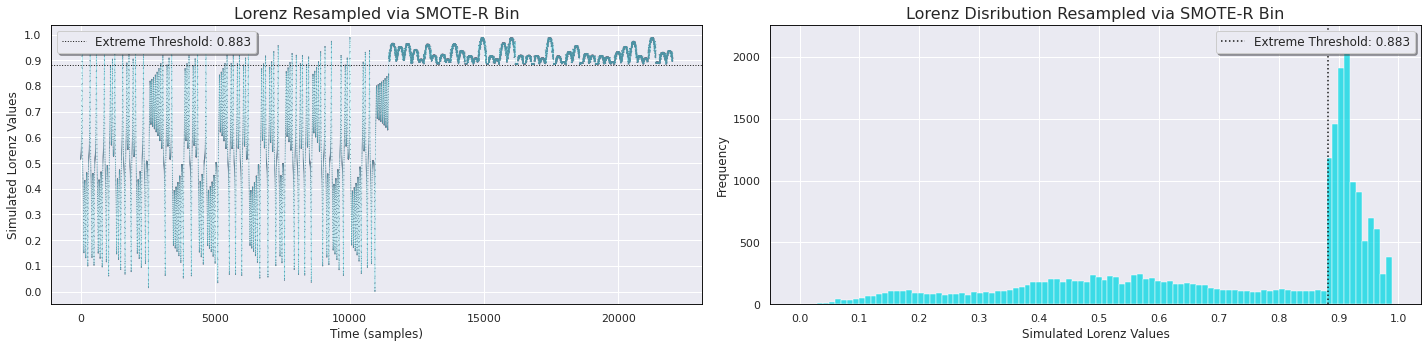

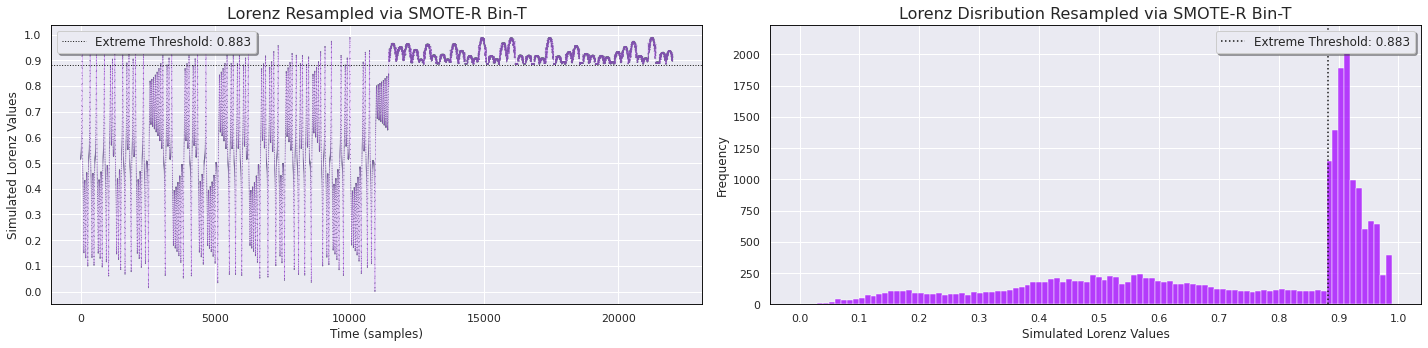

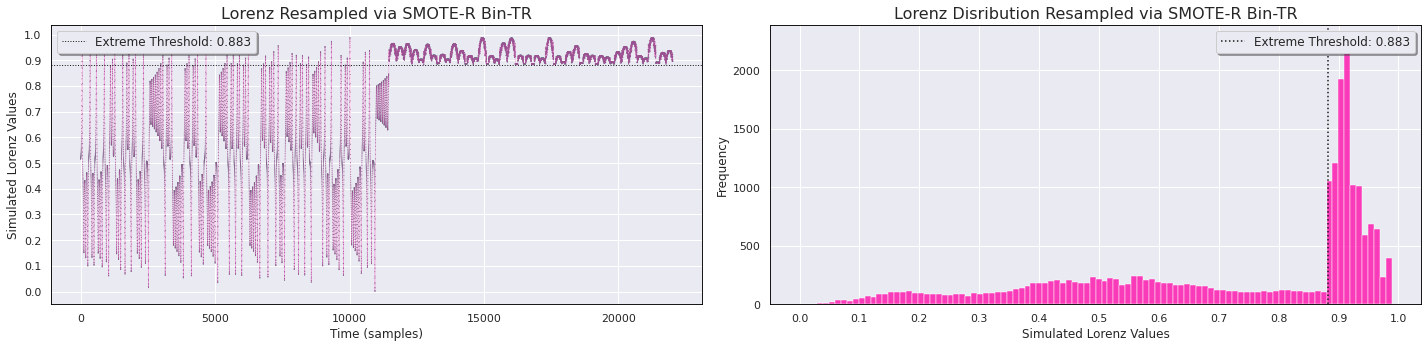

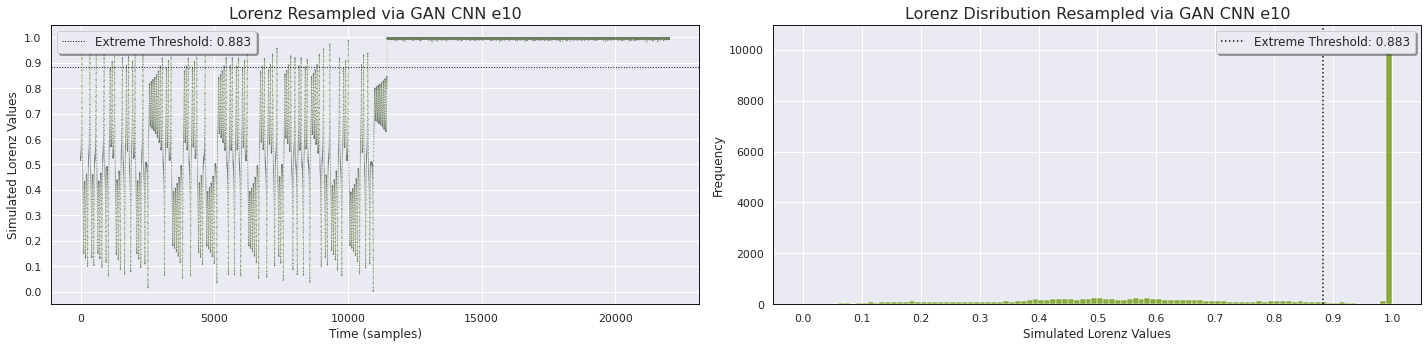

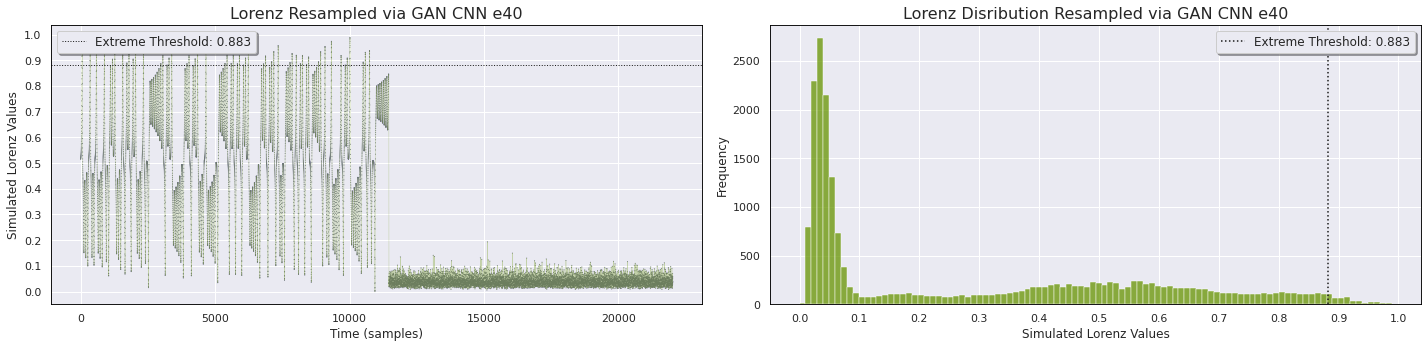

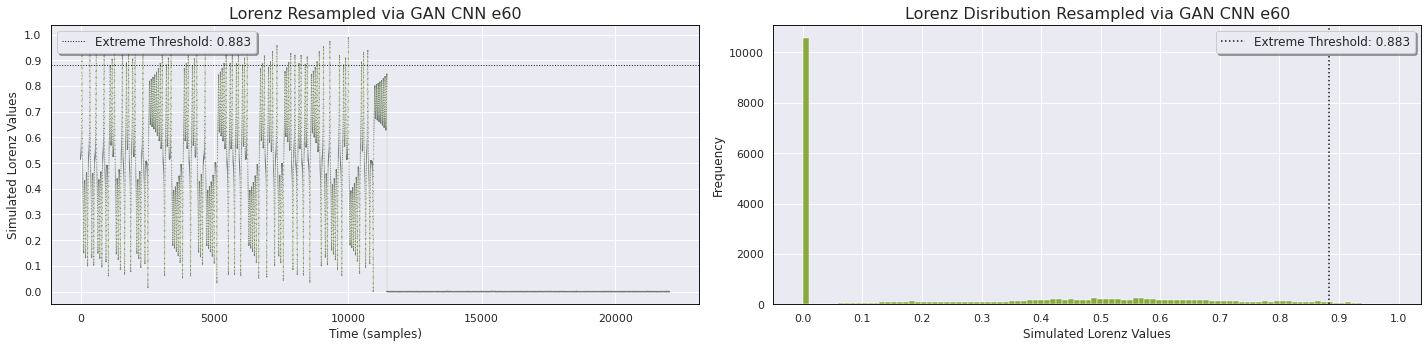

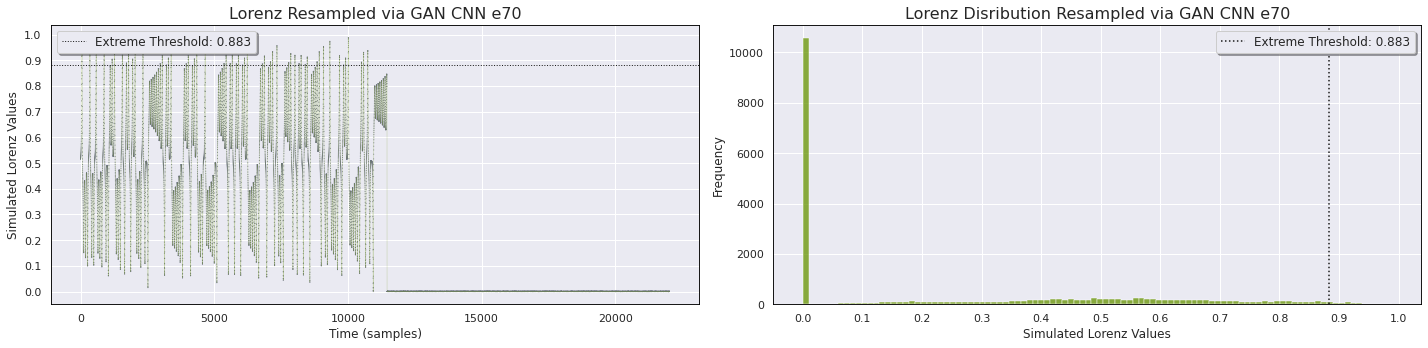

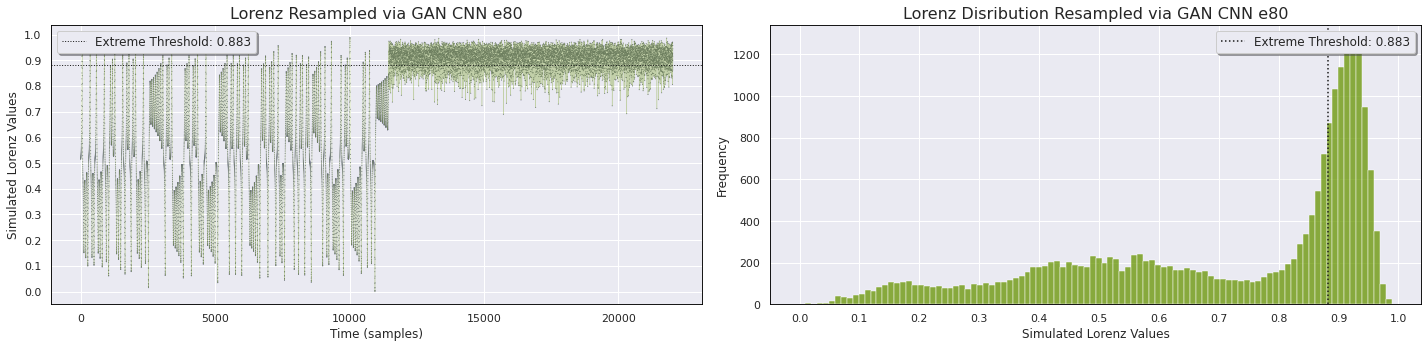

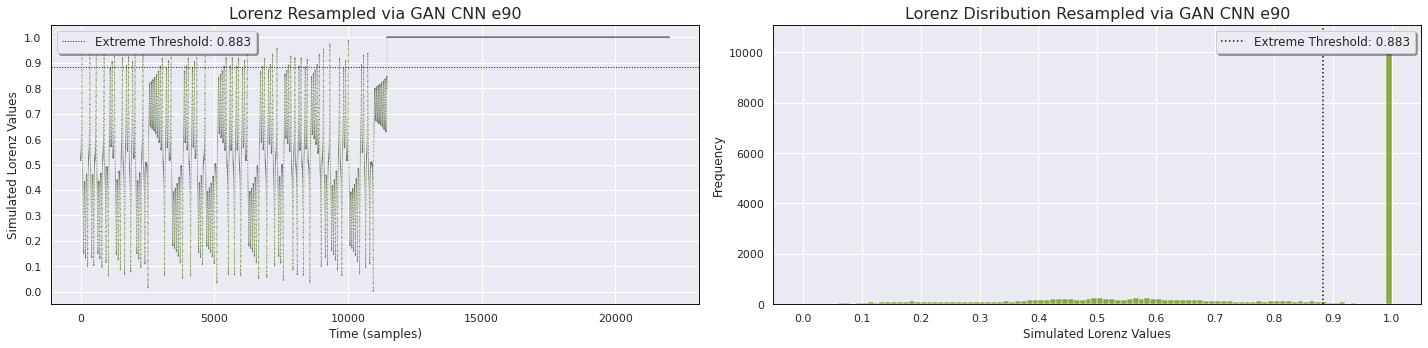

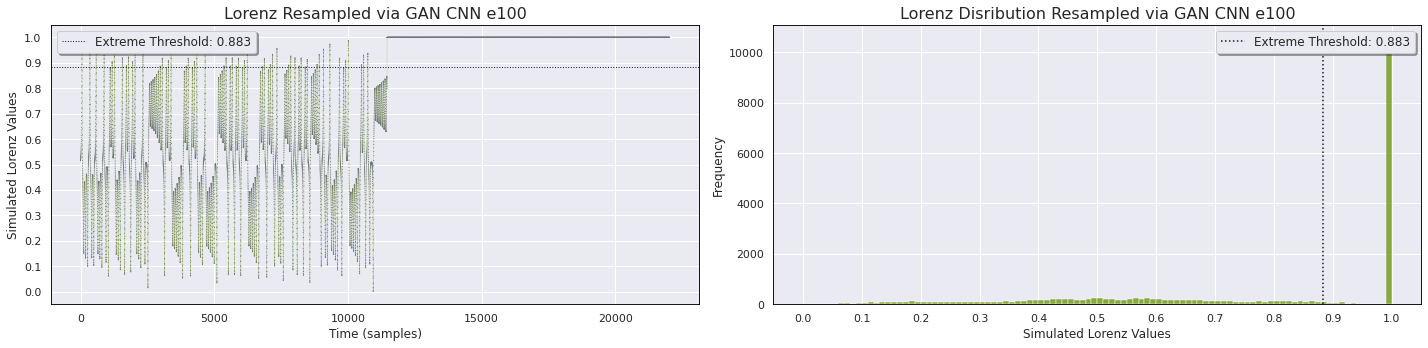

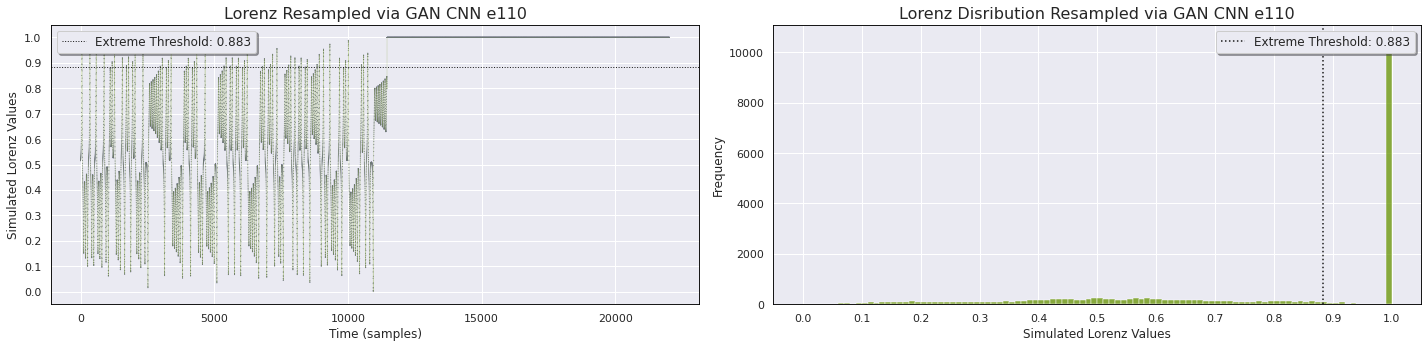

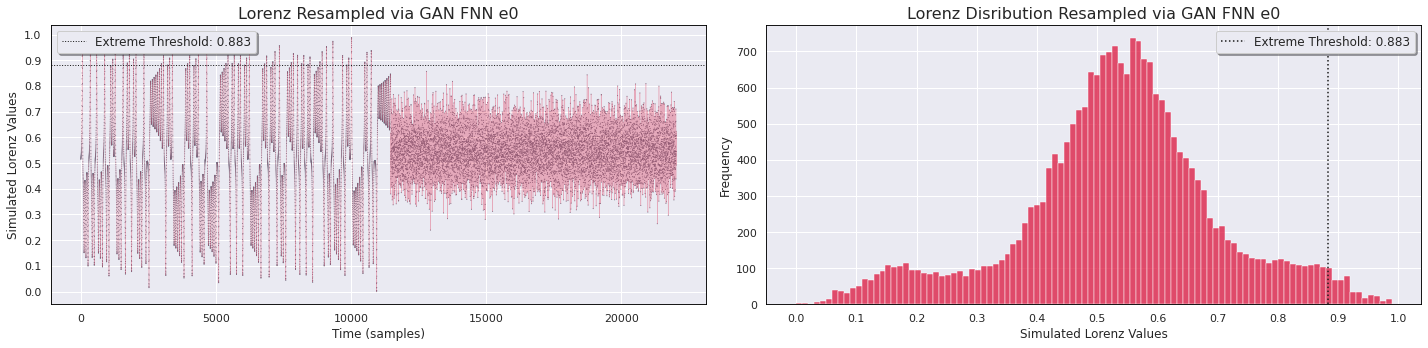

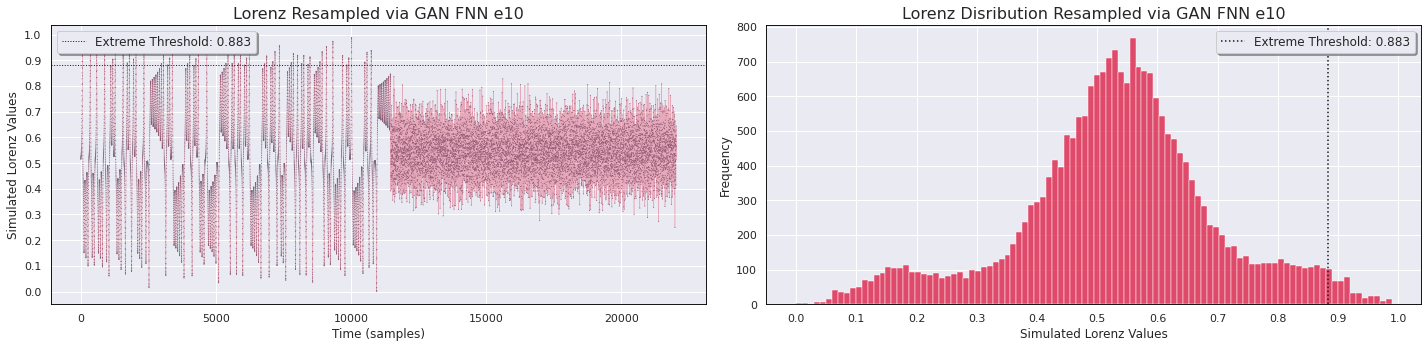

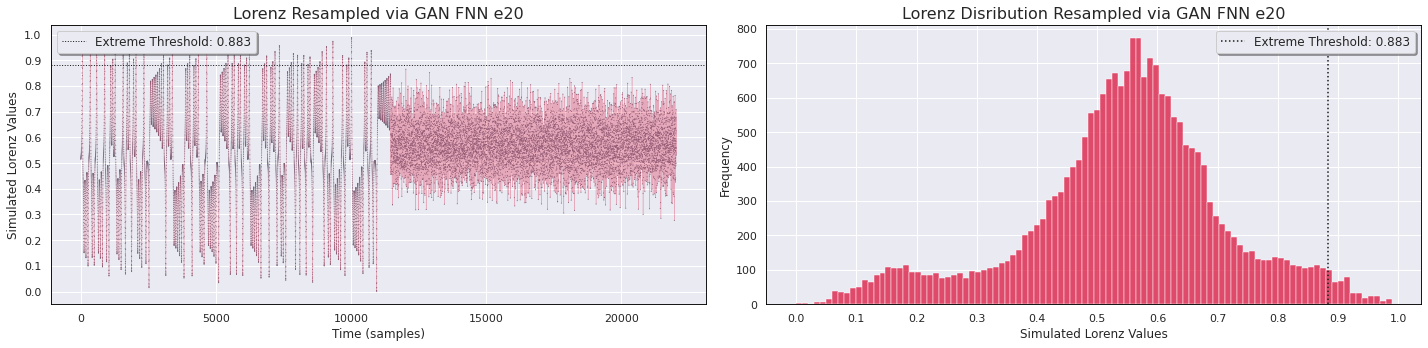

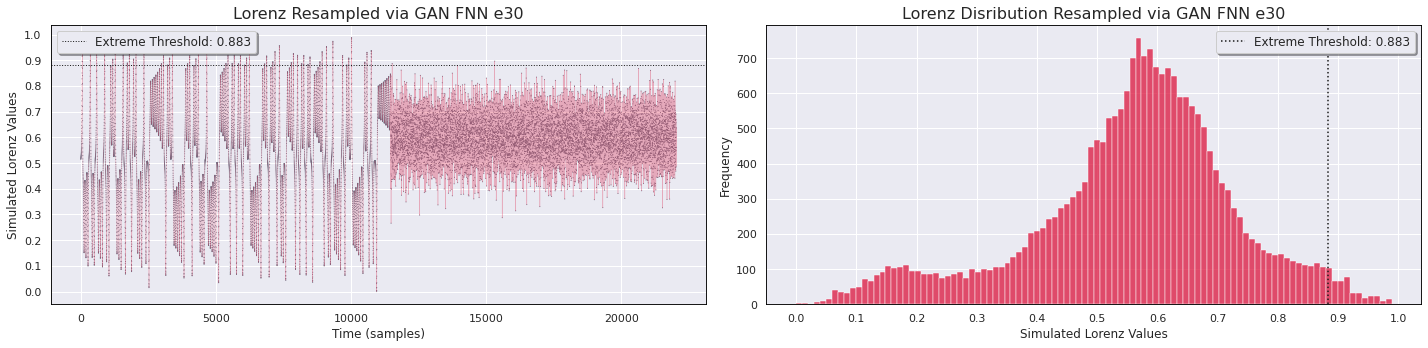

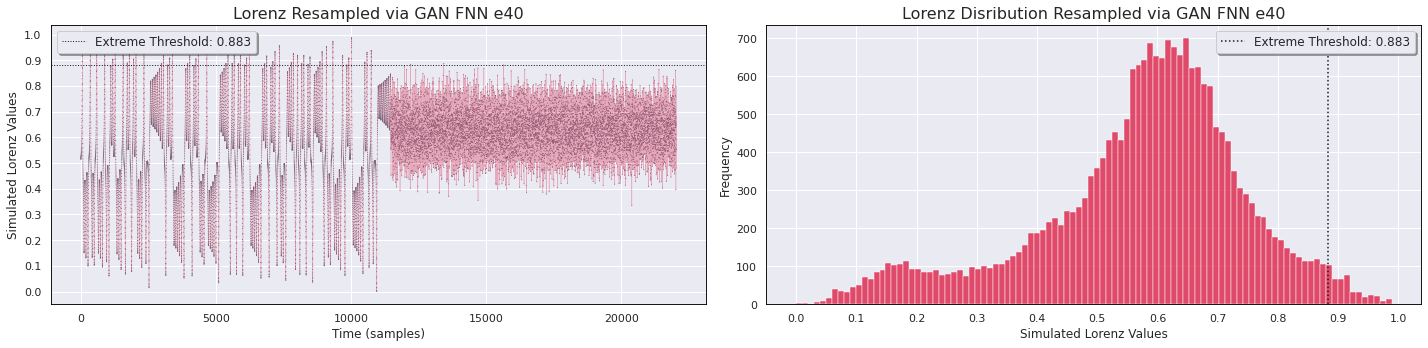

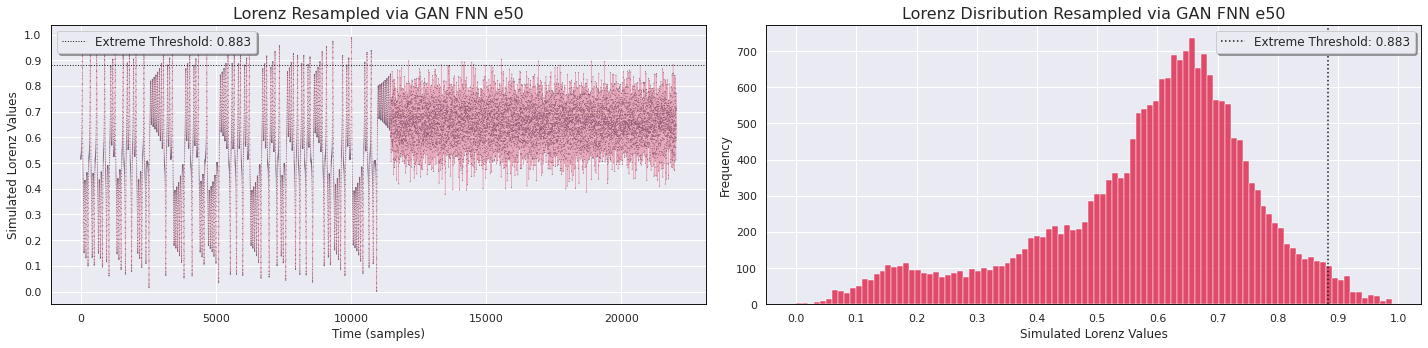

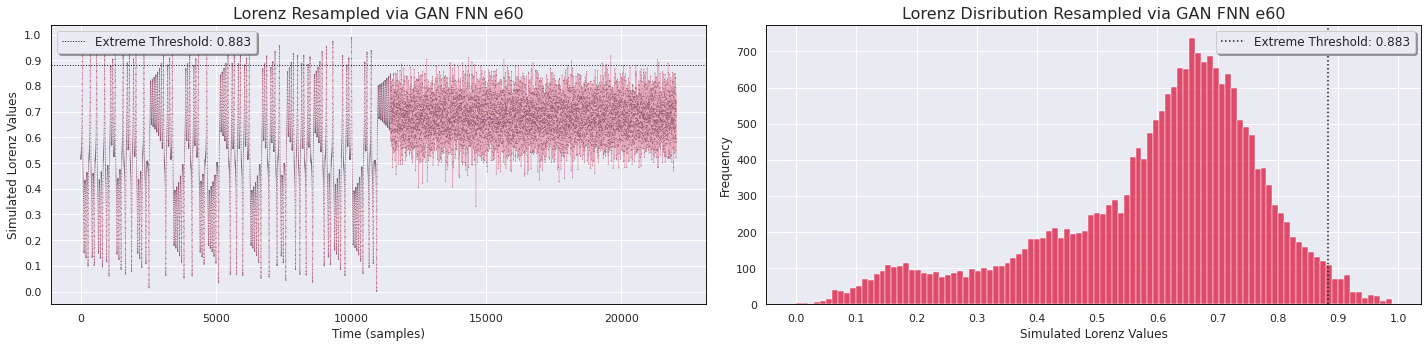

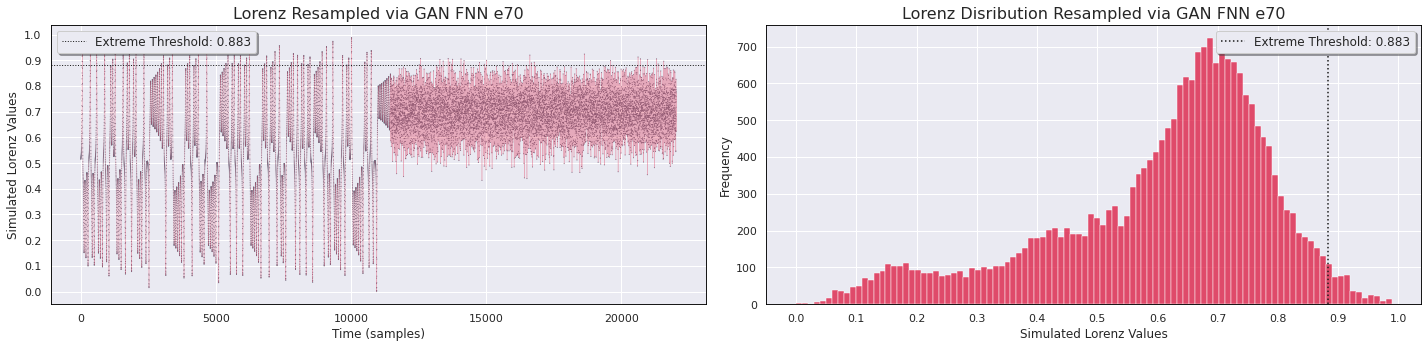

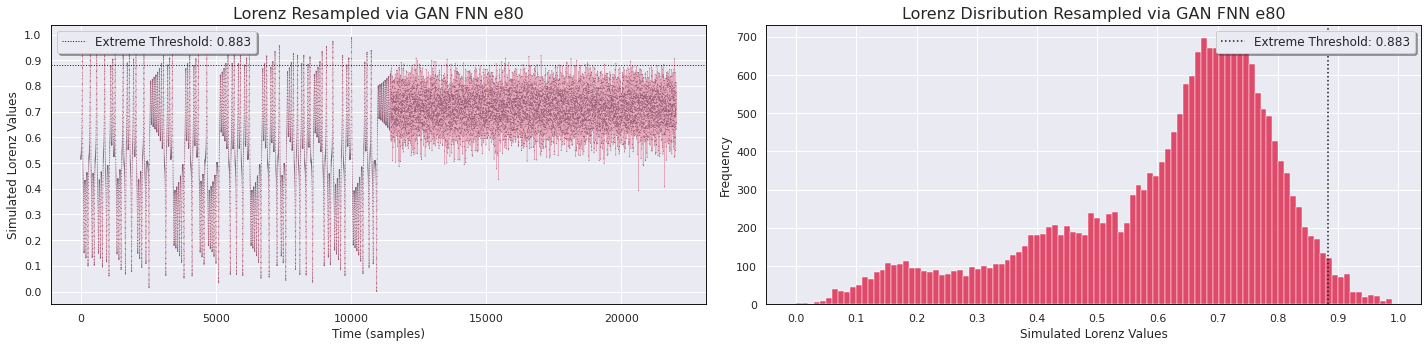

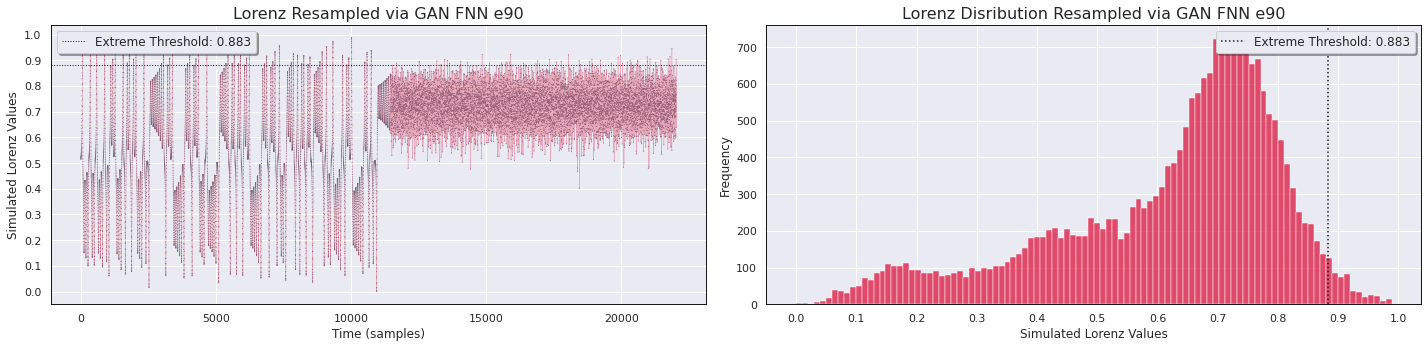

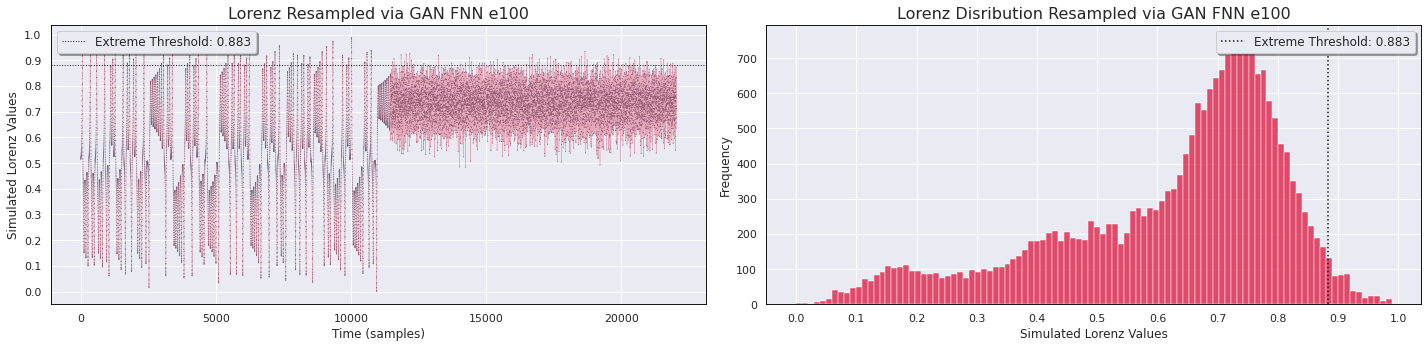

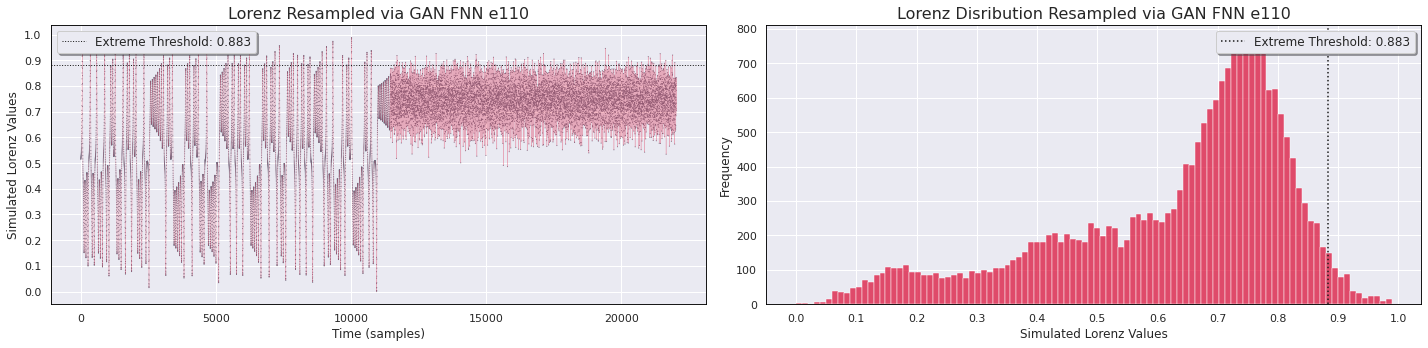

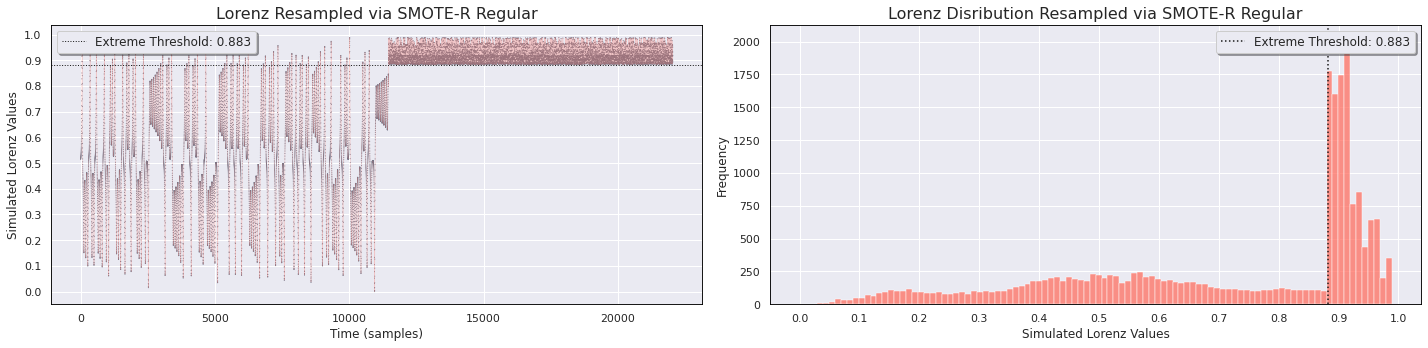

In [11]:
#import plt_utils as pu
#importlib.reload(pu)
#only plots first step out in each embedded
pu.PlotResampledResults(resampling_results, k_X.shape[0], N_STEPS_OUT,EXTREMES_THRESHOLD, TVAR, DATA_NAME)

### Remove Bad GANs

Save time training the forecasters by removing GANs that will clearly generate bad results

In [12]:
all_resampling_results = resampling_results.copy() #save a copy just incase
to_delete = ['GAN_CNN_e0', 'GAN_CNN_e10', 'GAN_CNN_e20', 'GAN_CNN_e30', 'GAN_CNN_e40', 'GAN_CNN_e50', 'GAN_CNN_e60', 'GAN_CNN_e70', 'GAN_CNN_e80', 'GAN_CNN_e90', 'GAN_FNN_e0', 'GAN_FNN_e10', 'GAN_FNN_e20', 'GAN_FNN_e30', 'GAN_FNN_e40', 'GAN_FNN_e50', 'GAN_FNN_e60', 'GAN_FNN_e70', 'GAN_FNN_e80', 'GAN_FNN_e90']
print(resampling_results.keys())
for d in to_delete:
    del resampling_results[d]
print(resampling_results.keys())

dict_keys(['SMOTER_bin', 'SMOTER_bin_t', 'SMOTER_bin_r', 'SMOTER_bin_tr', 'GAN_CNN_e0', 'GAN_CNN_e10', 'GAN_CNN_e20', 'GAN_CNN_e30', 'GAN_CNN_e40', 'GAN_CNN_e50', 'GAN_CNN_e60', 'GAN_CNN_e70', 'GAN_CNN_e80', 'GAN_CNN_e90', 'GAN_CNN_e100', 'GAN_CNN_e110', 'GAN_FNN_e0', 'GAN_FNN_e10', 'GAN_FNN_e20', 'GAN_FNN_e30', 'GAN_FNN_e40', 'GAN_FNN_e50', 'GAN_FNN_e60', 'GAN_FNN_e70', 'GAN_FNN_e80', 'GAN_FNN_e90', 'GAN_FNN_e100', 'GAN_FNN_e110', 'SMOTER_regular'])
dict_keys(['SMOTER_bin', 'SMOTER_bin_t', 'SMOTER_bin_r', 'SMOTER_bin_tr', 'GAN_CNN_e100', 'GAN_CNN_e110', 'GAN_FNN_e100', 'GAN_FNN_e110', 'SMOTER_regular'])


# **Running Forecasting Experiments**

**Init Evaluator object for model eval metrics**

In [13]:
import evaluator as ev
importlib.reload(ev)

#NOTE: evaler_params must include CaseWeight else errors in MODEL_LSTM
evaluator_params = { "RMSE": {},
                     "RMSERare": {},
                     "Utility": {'m':0.5},
                     "CaseWeight": {'m':0.5},
                     "PrecisionRecall": {},
                     "FScore": {'beta':0.5},
                     #"RelevanceROC": {},
                   }
EVALERS = {}
for f in FORECASTERS:
    EVALERS[f] = ev.Evaluator(evaluator_params, RELEVANCE_THRESHOLD, RELEVANCE_FUNCTION)

#EVALER = ev.Evaluator(evaluator_params, RELEVANCE_THRESHOLD, RELEVANCE_FUNCTION)
RECORDER.save_param_dict({"Evaluator":evaluator_params})

**Train and evaluate an LSTM for each resampling strategy**

In [ ]:
NUM_EXPERIMENTS = 10

def main(time_step, X_train, X_test, Y_train, Y_test, resampling_results, evalers, recorder, train_params):   
    recorder.log_print(f"Starting forecasting experiments with num_exps: {train_params['num_exp']} and epochs: {train_params['epochs']}")
    recorder.save_param_dict({"Forecasting":{"NumExp":train_params['num_exp'], "nEpochs": train_params['epochs'], "hidden":train_params['hidden']}})
    
    forecast_results = {}
    for f in FORECASTERS:
        print(f"############## no_resample : {f} ##############")
        if f == "LSTM":
            best_predict_test, best_predict_train, best_cw, best_model = fmod.MODEL_LSTM(X_train, X_test, Y_train, Y_test, "no_resample", train_params, evalers[f], recorder.log_print)
        else:
            best_predict_test, best_predict_train, best_cw, best_model = fmod.MODEL_CNN(X_train, X_test, Y_train, Y_test, "no_resample", train_params, evalers[f], recorder.log_print)
    
        results = {'predict_test':best_predict_test,'predict_train':best_predict_train,'X_train':X_train,'Y_train':Y_train,'model':best_model}
        forecast_results[f] = {}
        forecast_results[f]['no_resample'] = results
    
    
    for key in resampling_results.keys():
        res = resampling_results[key]
        X_res = res[:,:(N_STEPS_IN*N_FVARS)]
        X_res = X_res.reshape((X_res.shape[0],N_STEPS_IN,N_FVARS))
        Y_res = res[:,(N_STEPS_IN*N_FVARS):]
        for f in FORECASTERS:
            print(f"############## {key} : {f} ##############")
            if f == "LSTM":
                best_predict_test, best_predict_train, best_cw, best_model = fmod.MODEL_LSTM(X_res, X_test, Y_res, Y_test, key, train_params, evalers[f], recorder.log_print)
            else:
                best_predict_test, best_predict_train, best_cw, best_model = fmod.MODEL_CNN(X_res, X_test, Y_res, Y_test, key, train_params, evalers[f], recorder.log_print)
        
            results = {'predict_test':best_predict_test,'predict_train':best_predict_train,'X_train':X_res,'Y_train':Y_res,'model':best_model}
            forecast_results[f][key] = results
    
    return forecast_results

TRAIN_PARAMS = {
        'num_exp': NUM_EXPERIMENTS, 
        'n_steps_in': N_STEPS_IN,
        'n_steps_out': N_STEPS_OUT,
        'epochs': 100,
        'hidden': 100,
        'forecast_dir': FORECAST_DIR,
        'n_fvars': N_FVARS
    }

forecast_results = main(N_STEPS_IN, X_train, X_test, Y_train, Y_test, resampling_results, EVALERS, RECORDER, TRAIN_PARAMS)

print("$$$$ FINISHED FORECASTING EXPERIMENTS $$$$")

LOG: 04:15:11:257 Starting forecasting experiments with num_exps: 10 and epochs: 100

############## no_resample : LSTM ##############


2023-10-26 04:15:11.384105: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-26 04:15:11.396801: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-26 04:15:11.397587: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-10-26 04:15:11.397874: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-10-26 04:15:11.397942: W tensorf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 5)                 505       
                                                                 
Total params: 41,305
Trainable params: 41,305
Non-trainable params: 0
_________________________________________________________________
LOG: 04:15:11:697 Starting LSTM forecaster training on no_resample

LOG: 04:15:11:698 	Experiment 1 in progress

154/154 [==============================] - 0s 2ms/step
LOG: 04:16:45:729 	Experiment 2 in progress

154/154 [==============================] - 0s 2ms/step
LOG: 04:18:18:450 	Experiment 3 in progress

154/154 [==============================] - 0s 2ms/step
LOG: 04:19:51:200 	Experiment 4 in progress

154/154 [==========================

 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 50)                3250      
                                                                 
 dense_5 (Dense)             (None, 5)                 255       
                                                                 
Total params: 3,601
Trainable params: 3,601
Non-trainable params: 0
_________________________________________________________________
LOG: 05:03:55:643 Starting CNN forecaster training on SMOTER_bin

LOG: 05:03:55:643 	Experiment 1 in progress

154/154 [==============================] - 0s 811us/step
LOG: 05:04:33:846 	Experiment 2 in progress

154/154 [==============================] - 0s 786us/step
LOG: 05:05:11:304 	Experiment 3 in progress

154/154 [==============

 dense_9 (Dense)             (None, 5)                 505       
                                                                 
Total params: 41,305
Trainable params: 41,305
Non-trainable params: 0
_________________________________________________________________
LOG: 05:45:59:437 Starting LSTM forecaster training on SMOTER_bin_r

LOG: 05:45:59:439 	Experiment 1 in progress

154/154 [==============================] - 0s 2ms/step
LOG: 05:48:57:234 	Experiment 2 in progress

154/154 [==============================] - 0s 2ms/step
LOG: 05:51:54:364 	Experiment 3 in progress

154/154 [==============================] - 0s 2ms/step
LOG: 05:54:51:141 	Experiment 4 in progress

154/154 [==============================] - 0s 2ms/step
LOG: 05:57:49:988 	Experiment 5 in progress

154/154 [==============================] - 0s 2ms/step
LOG: 06:00:47:105 	Experiment 6 in progress

154/154 [==============================] - 0s 2ms/step
LOG: 06:03:45:459 	Experiment 7 in progress

154/154 [=========

                                                                 
 dense_14 (Dense)            (None, 5)                 255       
                                                                 
Total params: 3,601
Trainable params: 3,601
Non-trainable params: 0
_________________________________________________________________
LOG: 06:51:17:319 Starting CNN forecaster training on SMOTER_bin_tr

LOG: 06:51:17:319 	Experiment 1 in progress

154/154 [==============================] - 0s 841us/step
LOG: 06:51:55:462 	Experiment 2 in progress

154/154 [==============================] - 0s 837us/step
LOG: 06:52:33:099 	Experiment 3 in progress

154/154 [==============================] - 0s 812us/step
LOG: 06:53:11:066 	Experiment 4 in progress

154/154 [==============================] - 0s 864us/step
LOG: 06:53:48:534 	Experiment 5 in progress

154/154 [==============================] - 0s 858us/step
LOG: 06:54:26:675 	Experiment 6 in progress

154/154 [==============================] - 0

LOG: 07:31:48:046 Starting LSTM forecaster training on GAN_CNN_e110

LOG: 07:31:48:049 	Experiment 1 in progress

154/154 [==============================] - 0s 2ms/step
LOG: 07:34:37:622 	Experiment 2 in progress

154/154 [==============================] - 0s 2ms/step
LOG: 07:37:25:901 	Experiment 3 in progress

154/154 [==============================] - 0s 2ms/step
LOG: 07:40:14:657 	Experiment 4 in progress

154/154 [==============================] - 0s 2ms/step
LOG: 07:43:03:132 	Experiment 5 in progress

154/154 [==============================] - 0s 2ms/step
LOG: 07:45:52:081 	Experiment 6 in progress

154/154 [==============================] - 0s 2ms/step
LOG: 07:48:40:340 	Experiment 7 in progress

154/154 [==============================] - 0s 2ms/step
LOG: 07:51:28:210 	Experiment 8 in progress

154/154 [==============================] - 0s 2ms/step
LOG: 07:54:16:234 	Experiment 9 in progress

154/154 [==============================] - 0s 2ms/step
LOG: 07:57:05:062 	Experiment 1

## *SAVE EVALER RESULTS ---- DON'T FORGET*

In [ ]:
for f in FORECASTERS:
    RECORDER.save_all_evaler_exps(EVALERS[f].getResultsDf(), f)

### Plot Actual vs Predicted

In [ ]:
#Uncomment if you want to change stuff in plt_utils mid-session
#import plt_utils as pu
#importlib.reload(pu)
#Need to uncomment this is you're saving figures:
#pu.set_save_figs(True, RECORDER.figures_path)
#print(forecast_results)
#PLOT PRED VS ACTUAL + SAVE_EVAL_RESULTS
for f in FORECASTERS:
    for key in forecast_results[f].keys():
        y_predict_test = forecast_results[f][key]['predict_test']
        #Plot a single Actual vs Predicted figure for only one chosen step out: 0 for first step
        pu.PlotPredVsActual1D(Y_test, y_predict_test, key, EXTREMES_THRESHOLD, TVAR, DATA_NAME, f, 0)
        #Plot a Actual vs Predicted for all steps out in one figure
        pu.PlotPredVsActualSteps(Y_test, y_predict_test, key, EXTREMES_THRESHOLD, TVAR, DATA_NAME, N_STEPS_OUT, f)
        #Save forecasting model
        RECORDER.save_LSTM(forecast_results[f][key]['model'], key)
        #TODO: save CNN and LSTM with same function

### Record KS Statistic and Plot Extremes Distribution for Each Resampling Strategy

In [ ]:
#Uncomment if you want to change stuff in plt_utils mid-session
#import plt_utils as pu
#importlib.reload(pu)
#Need to uncomment this is you're saving figures:
#pu.set_save_figs(True, RECORDER.figures_path)
from scipy.stats import ks_2samp
import scipy.stats as stats

step_out = 0
#get extremes for original data
y_orig_rel = RELEVANCE_FUNCTION.__call__(Y_train[:,step_out])
rare_mask = [val >= RELEVANCE_THRESHOLD for val in y_orig_rel]
y_orig_rare = Y_train[rare_mask]
ks_results = []
for key, res in resampling_results.items():
    #get extremes for resampled data
    y_res = res[:,(N_STEPS_IN*N_FVARS):]
    y_rel = RELEVANCE_FUNCTION.__call__(y_res[:,step_out])
    rare_mask = [val >= RELEVANCE_THRESHOLD for val in y_rel]
    y_rare = y_res[rare_mask]

    # Perform the Kolmogorov-Smirnov test
    statistic, p_value = ks_2samp(y_orig_rare[:,step_out], y_rare[:,step_out])
    print(f"KS statistic: {statistic}, p-value: {p_value}")
    ks_results.append({'Res':key, 'ksStat':statistic, 'pValue':p_value})
    #Plot extremes hist and cdf for each strategy vs original data
    pu.PlotExremesDistribution(y_orig_rare, y_rare, key, step_out, EXTREMES_THRESHOLD, TVAR, DATA_NAME)
    

ks_df = pd.DataFrame(ks_results)
RECORDER.save_ks(ks_df)

### Prepare Data for Comparison Plots

If we include all strategies on the comparison plots they will be really cluttered and almost useless to the reader. In the following cell we choose the best CNN_GAN, FNN_GAN, and SMOTER_bin approach from the RMSERare of the forecasting results and only include these on the comparison plots. 

Later we'll also use this cell to load the base resampling results / eval metrics to include on the comparison plots along side the next generation of resampling strategies

In [ ]:
def calculate_mean(lst):
    return sum(lst) / len(lst)

#Combine EVALER from loaded experiments
#Combine resampling results from loaded experiments
#np.loadtxt('test.txt', delimiter=',', dtype=float)

#TODO: come up with a way to make a copy of evaler so we don't have to filter best strategies for the clustered bar plots

#best_resampling_results will contain best GANs, best SMOTERs
best_resampling_results = resampling_results.copy()
best_cnn_gan = ""
best_fnn_gan = ""
best_bin = ""

def get_best_resampling(forecaster, best, evaler, metric, recorder):
    exp_sum = evaler.getExperimentSummaryDf(metric)
    #get best CNN_GAN if used
    cnn_exp_sum = exp_sum[exp_sum['Res'].str.contains("GAN_CNN")]
    if not cnn_exp_sum.empty:
        #apply mean to all rows
        cnn_exp_sum[f"{metric}_Test_Mean"] = cnn_exp_sum[f"{metric}_Test_Mean"].apply(calculate_mean)
        max_cw_idx = cnn_exp_sum[f"{metric}_Test_Mean"].idxmin()
        best_cnn_gan = cnn_exp_sum.at[max_cw_idx, "Res"]
        print(f"Best CNN_GAN for {forecaster}: {best_cnn_gan}")
        keys_to_delete = [key for key in best['resampling_results'].keys() if "GAN_CNN" in key and key != best_cnn_gan]
        print(f"deleting keys: {keys_to_delete}")
        for key in keys_to_delete:
            del best['resampling_results'][key]
        best['cnn_gan'] = best_cnn_gan
        ekey = int(best_cnn_gan.split('_')[-1][1:])
        recorder.save_gan(CNN_GENS[ekey], CNN_DISCS[ekey], "CNN", best_cnn_gan)
    
    #get best FNN_GAN if used
    fnn_exp_sum = exp_sum[exp_sum['Res'].str.contains("GAN_FNN")]
    if not fnn_exp_sum.empty:
        #apply mean to all rows
        fnn_exp_sum[f"{metric}_Test_Mean"] = fnn_exp_sum[f"{metric}_Test_Mean"].apply(calculate_mean)
        max_cw_idx = fnn_exp_sum[f"{metric}_Test_Mean"].idxmin()
        best_fnn_gan = fnn_exp_sum.at[max_cw_idx, "Res"]
        print(f"Best FNN_GAN for {forecaster}: {best_fnn_gan}")
        keys_to_delete = [key for key in best['resampling_results'].keys() if "GAN_FNN" in key and key != best_fnn_gan]
        print(f"deleting keys: {keys_to_delete}")
        for key in keys_to_delete:
            del best['resampling_results'][key]
        best['fnn_gan'] = best_fnn_gan
        ekey = int(best_fnn_gan.split('_')[-1][1:])
        RECORDER.save_gan(FNN_GENS[ekey], FNN_DISCS[ekey], "FNN", best_fnn_gan)
    #get best SMOTER_bin if used
    bin_exp_sum = exp_sum[exp_sum['Res'].str.contains("SMOTER_bin")] 
    if not bin_exp_sum.empty:
        bin_exp_sum[f"{metric}_Test_Mean"] = bin_exp_sum[f"{metric}_Test_Mean"].apply(calculate_mean)
        max_cw_idx = bin_exp_sum[f"{metric}_Test_Mean"].idxmin()
        best_bin = bin_exp_sum.at[max_cw_idx, "Res"]
        print(f"Best SMOTER bin for {forecaster}: {best_bin}")
        keys_to_delete = [key for key in best['resampling_results'].keys() if "SMOTER_bin" in key and key != best_bin]
        print(f"deleting keys: {keys_to_delete}")
        for key in keys_to_delete:
            del best['resampling_results'][key]
        best['bin'] = best_bin
    return best #?
                                                         

BEST_RESULTS = {}
for f in FORECASTERS:
    BEST_RESULTS[f] = {'resampling_results': resampling_results.copy(), 'cnn_gan': "", 'fnn_gan': "", "bin": ""}
    #do below stuff with argument 'f'
    BEST_RESULTS[f] = get_best_resampling(f, BEST_RESULTS[f], EVALERS[f], 'RMSERare', RECORDER) #?
    RECORDER.save_resample_results_np(BEST_RESULTS[f]['resampling_results'], f)


#load all resampling results
#COMBINE_RESAMPLING_RESULTS_DIR = Path("Sessions/Bike/2023-October-13 13-41-03-532984").joinpath("resample_results")

#add loaded resampling results to best_resampling_results
#best_resampling_results.update({file.stem: np.loadtxt(file, delimiter=',', dtype=float)
#                  for file in COMBINE_RESAMPLING_RESULTS_DIR.iterdir() if file.is_file()})

### Compare KDEs and CDFs

In [ ]:
#Uncomment if you want to change stuff in plt_utils mid-session
#import plt_utils as pu
#importlib.reload(pu)
#Need to uncomment this is you're saving figures:
#pu.set_save_figs(True, RECORDER.figures_path)
step_out = 0

#compare KDE, CDF
for f in FORECASTERS:
    pu.PlotKDECompare(Y_train, BEST_RESULTS[f]['resampling_results'], RELEVANCE_FUNCTION, RELEVANCE_THRESHOLD, step_out, N_STEPS_IN*N_FVARS, EXTREMES_THRESHOLD, TVAR, DATA_NAME, f)    
    pu.PlotCDFCompare(Y_train, BEST_RESULTS[f]['resampling_results'], RELEVANCE_FUNCTION, RELEVANCE_THRESHOLD, step_out, N_STEPS_IN*N_FVARS, EXTREMES_THRESHOLD, TVAR, DATA_NAME, f)    

### Plot Eval Results Aggregated Over All Steps

In [ ]:
#Uncomment if you want to change stuff in plt_utils mid-session
#import plt_utils as pu
#importlib.reload(pu)
#Need to uncomment this is you're saving figures:
#pu.set_save_figs(True, RECORDER.figures_path)


def calculate_mean(lst):
    return sum(lst) / len(lst)

#Just plot these metrics:
plot_metrics = ["CaseWeight", "Utility", "RMSERare", "RMSE", "FScore"]

ts = ["Train", "Test"] #one cluster for train, one for test results

#aggs options: 
aggs = ["Mean", "Std"]
## for "Mean" we get the mean of the eval metrics over all experiments and plot its average over time steps
## for "Std" we get the std of the eval metrics over all experiments and plot its average over time steps

#for f in FORECASTERS: EVALER[f], get best_cnn_gan, best_fnn_gan, best_bin from dict
#pass an argument to plotting function to specify f
for f in FORECASTERS:
    best_cnn_gan = BEST_RESULTS[f]['cnn_gan']
    best_fnn_gan = BEST_RESULTS[f]['fnn_gan']
    best_bin = BEST_RESULTS[f]['bin']
    for metric in plot_metrics:
        df_results = EVALERS[f].getExperimentSummaryDf(metric, True)
        df_results_train = EVALERS[f].getExperimentSummaryDf(metric, False)
        df_results[f"{metric}_Train_Mean"] = df_results_train[f"{metric}_Train_Mean"]
        df_results[f"{metric}_Train_Std"] = df_results_train[f"{metric}_Train_Std"]
        # Replace with the mean of the steps out lists
        df_results[f"{metric}_Train_Mean"] = df_results[f"{metric}_Train_Mean"].apply(calculate_mean)
        df_results[f"{metric}_Test_Mean"] = df_results[f"{metric}_Test_Mean"].apply(calculate_mean)
        df_results[f"{metric}_Train_Std"] = df_results[f"{metric}_Train_Std"].apply(calculate_mean)
        df_results[f"{metric}_Test_Std"] = df_results[f"{metric}_Test_Std"].apply(calculate_mean)
        for a in aggs:
            #remove any GAN_CNNs, GAN_FNNs, and SMOTER_bin strategies from the dataframe that aren't the best
            filtered_df = df_results[((df_results['Res'].str.contains('GAN_CNN|GAN_FNN')) & ((df_results['Res'] == best_cnn_gan) | (df_results['Res'] == best_fnn_gan))) | (~df_results['Res'].str.contains('GAN_CNN|GAN_FNN'))]
            filtered_df = filtered_df[((filtered_df['Res'].str.contains('SMOTER_bin')) & (filtered_df['Res'] == best_bin)) | (~filtered_df['Res'].str.contains('SMOTER_bin'))]
            '''
            filtered_df = df_results
            if best_cnn_gan:
                filtered_df = filtered_df[((filtered_df['Res'].str.contains('GAN_CNN')) & (filtered_df['Res'] == best_cnn_gan)) | (~filtered_df['Res'].str.contains('GAN_CNN'))]
            if best_fnn_gan:
                filtered_df = filtered_df[((filtered_df['Res'].str.contains('GAN_FNN')) & (filtered_df['Res'] == best_fnn_gan)) | (~filtered_df['Res'].str.contains('GAN_FNN'))]
            '''
            pu.PlotTrainTestBarResults(filtered_df, metric, a, DATA_NAME, N_STEPS_OUT, f)


### Plot Train and Test Eval Results Clustered By Steps Out

In [ ]:
#Uncomment if you want to change stuff in plt_utils mid-session
#import plt_utils as pu
#importlib.reload(pu)
#Need to uncomment this is you're saving figures:
#pu.set_save_figs(True, RECORDER.figures_path)



plot_metrics = ["CaseWeight", "Utility", "RMSERare", "RMSE", "FScore"]
ts = ["Train", "Test"]
aggs = ["Mean", "Std"]
#either plot mean or std of the experiments
for f in FORECASTERS:
    best_cnn_gan = BEST_RESULTS[f]['cnn_gan']
    best_fnn_gan = BEST_RESULTS[f]['fnn_gan']
    best_bin = BEST_RESULTS[f]['bin']
    for metric in plot_metrics:
        for t in ts:
            tb = True if t == "Test" else False
            df_results = EVALERS[f].getExperimentSummaryDf(metric, tb)
            for a in aggs:
                #filter out all GAN_CNNs, GAN_FNNs or SMOTER_bins that aren't the best
                filtered_df = df_results[((df_results['Res'].str.contains('GAN_CNN|GAN_FNN')) & ((df_results['Res'] == best_cnn_gan) | (df_results['Res'] == best_fnn_gan))) | (~df_results['Res'].str.contains('GAN_CNN|GAN_FNN'))]
                filtered_df = filtered_df[((filtered_df['Res'].str.contains('SMOTER_bin')) & (filtered_df['Res'] == best_bin)) | (~filtered_df['Res'].str.contains('SMOTER_bin'))]
                pu.PlotStepBarResults(filtered_df, metric, a, t, DATA_NAME, N_STEPS_OUT, f)